In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 8)

In [4]:
filename = "UK-60-HEI-policies.csv"
df1 = pd.read_csv(f'./policies/{filename}', encoding='utf-8')
# df1 = pd.read_csv('./policies/'+filename)

In [5]:
# Print the features of df1
print(df1.columns)

# Perform one-hot encoding
# df1 = pd.get_dummies(df1, columns=['Discipline'])
# Print the new features of df1
# print(df1.columns)

# Print first five rows of df1
print(df1.head())

Index(['Rank', 'Name', 'Filename', 'PolicyURL'], dtype='object')
   Rank                                              Name          Filename  \
0     1  London School of Economics and Political Science        01_LSE.rtf   
1     2                          University of St Andrews  02_stAndrews.pdf   
2     3                                 Durham University     03_Durham.rtf   
3     4                           University of Cambridge  04_cambridge.rtf   
4     5                              University of Oxford     05_oxford.rtf   

                                           PolicyURL  
0  https://www.lse.ac.uk/anthropology/study/AI-Po...  
1  https://www.st-andrews.ac.uk/policy/academic-p...  
2  https://www.durham.ac.uk/global-durham/global-...  
3  https://www.cambridgeinternational.org/exam-ad...  
4  https://www.ox.ac.uk/research/support-research...  


In [6]:
print('number of policies = ',len(df1))

number of policies =  58


In [7]:
import os
import io
import sys
import subprocess
import pandas as pd
from PyPDF2 import PdfReader
from striprtf.striprtf import rtf_to_text
import re

# use existing notebook variables if present, otherwise sensible defaults
text_dir = globals().get("text_dir", os.path.join(".", "policies", "UK58HEIpolicies_text"))
filename_col = globals().get("filename_col", "Filename") 
orig_csv = globals().get("filename", "UK-60-HEI-policies.csv")
out_base = os.path.splitext(orig_csv)[0] + "_with_file_text"
out_path = os.path.join(".", "policies", out_base + ".csv")

# ensure df1 exists (cells below may have created it)
if "df1" not in globals():
    csv_path = os.path.join(".", "policies", orig_csv)
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Cannot find CSV at {csv_path}")
    df1 = pd.read_csv(csv_path, encoding="utf-8", dtype=str)

# # attempt imports for pdf/rtf handling (optional)
# try:
# except Exception:
#     PdfReader = None


# rtf_to_text = None

def _read_plain(p):
    try:
        with open(p, "r", encoding="utf-8", errors="replace") as fh:
            return fh.read().strip()
    except Exception:
        try:
            with open(p, "r", encoding="latin-1", errors="replace") as fh:
                return fh.read().strip()
        except Exception:
            return None

def _read_pdf_pypdf2(p):
    if PdfReader is None:
        return None
    try:
        reader = PdfReader(p)
        pages = []
        for page in reader.pages:
            text = page.extract_text()
            if text:
                pages.append(text)
        return "\n".join(pages).strip() if pages else None
    except Exception:
        return None

def _read_pdf_pdftotext(p):
    # use pdftotext if available: pdftotext <pdf> - (writes to stdout)
    try:
        proc = subprocess.run(["pdftotext", "-enc", "UTF-8", p, "-"], stdout=subprocess.PIPE, stderr=subprocess.DEVNULL, check=True)
        txt = proc.stdout.decode("utf-8", errors="replace").strip()
        return txt if txt else None
    except Exception:
        return None

def _read_rtf_striprtf(p):
    if rtf_to_text is None:
        return None
    try:
        with open(p, "r", encoding="utf-8", errors="replace") as fh:
            data = fh.read()
        return rtf_to_text(data).strip()
    except Exception:
        return None

def _read_rtf_fallback(p):
    # very naive fallback: remove RTF control words and groups
    try:
        raw = _read_plain(p)
        if not raw:
            return None
        # strip typical RTF braces and backslash control words
        txt = re.sub(r"\\[a-zA-Z]+\d*", "", raw)      # remove control words
        txt = re.sub(r"{\\.*?}", "", txt)             # remove groups starting with backslash
        txt = re.sub(r"[{}\\]", "", txt)              # remove stray braces/backslashes
        txt = re.sub(r"\s+", " ", txt).strip()
        return txt
    except Exception:
        return None

def read_file_text(fname):
    if not isinstance(fname, str) or not fname.strip():
        return None
    candidates = [
        fname,
        os.path.join(text_dir, fname),
        os.path.join(text_dir, os.path.basename(fname))
    ]
    # if fname has no extension, try common ones
    ext = os.path.splitext(fname)[1].lower()
    for p in candidates:
        if not p:
            continue
        if os.path.exists(p) and os.path.isfile(p):
            # choose reader by extension
            if p.lower().endswith(".pdf"):
                # try PyPDF2 first, then pdftotext
                txt = _read_pdf_pypdf2(p)
                if txt:
                    return txt
                txt = _read_pdf_pdftotext(p)
                if txt:
                    return txt
                # last resort: attempt plain read (binary decode) and hope for text
                return _read_plain(p)
            elif p.lower().endswith(".rtf"):
                txt = _read_rtf_striprtf(p)
                if txt:
                    return txt
                txt = _read_rtf_fallback(p)
                if txt:
                    return txt
                return _read_plain(p)
            else:
                # try plain text first
                txt = _read_plain(p)
                if txt:
                    return txt
                # fallback: if pdf-like content, try pdf handlers
                if p.lower().endswith(".pdf") or b"%PDF" in open(p, "rb").read(8):
                    txt = _read_pdf_pypdf2(p) or _read_pdf_pdftotext(p)
                    if txt:
                        return txt
    return None

# Ensure filename column exists (case-insensitive search)
fc = None
for c in df1.columns:
    if c.lower() == filename_col.lower():
        fc = c
        break
if fc is None:
    # try common names
    for cand in ("filename", "file", "file_name", "fileName", "Filename"):
        if cand in df1.columns:
            fc = cand
            break
if fc is None:
    raise ValueError(f"Could not find a filename column in the dataframe. Available cols: {list(df1.columns)}")

# Create/overwrite 'file_text' column by reading files
new_col = "Policy Text"
df1[new_col] = None

read_count = 0
missing_idxs = []
for idx, fname in df1[fc].fillna("").astype(str).items():
    txt = read_file_text(fname)
    if txt:
        df1.at[idx, new_col] = txt
        read_count += 1
    else:
        missing_idxs.append(idx)

print(f"Read text for {read_count} rows; {len(missing_idxs)} missing/unreadable (using column '{fc}').")

# Save augmented CSV
os.makedirs(os.path.join(".", "policies"), exist_ok=True)
df1.to_csv(out_path, index=False, encoding="utf-8")
print(f"Saved augmented CSV to: {out_path}")

Read text for 58 rows; 0 missing/unreadable (using column 'Filename').
Saved augmented CSV to: ./policies/UK-60-HEI-policies_with_file_text.csv


In [8]:
# Load CSV into df1 (prefer augmented CSV if available)
csv_candidates = []
if 'out_path' in globals() and out_path:
    csv_candidates.append(out_path)
if 'out_name' in globals() and out_name:
    csv_candidates.append(os.path.join(".", "policies", out_name))
if 'filename' in globals() and filename:
    csv_candidates.append(os.path.join(".", "policies", filename))
# last fallback: current working dir
if 'filename' in globals() and filename:
    csv_candidates.append(filename)

loaded = False
for p in csv_candidates:
    if p and os.path.exists(p) and os.path.isfile(p):
        df1 = pd.read_csv(p, encoding="utf-8", dtype=str)
        print(f"Loaded CSV: {p} -> df1 shape: {df1.shape}")
        loaded = True
        break

if not loaded:
    raise FileNotFoundError(f"Could not find any of the candidate CSVs: {csv_candidates}")

Loaded CSV: ./policies/UK-60-HEI-policies_with_file_text.csv -> df1 shape: (58, 5)


In [9]:
from IPython.display import display

# display top 5 rows of the dataframe
display(df1.head())

,Rank,Name,Filename,PolicyURL,Policy Text
0,1,London School of Economics and Political Science,01_LSE.rtf,https://www.lse.ac.uk/anthropology/study/AI-Po...,AI Policy\n\nAI Policy\nAs a student in the De...
1,2,University of St Andrews,02_stAndrews.pdf,https://www.st-andrews.ac.uk/policy/academic-p...,The University of St Andrews is a charity regi...
2,3,Durham University,03_Durham.rtf,https://www.durham.ac.uk/global-durham/global-...,Al in Global Opportunity applications\nIt is u...
3,4,University of Cambridge,04_cambridge.rtf,https://www.cambridgeinternational.org/exam-ad...,The use of generative AI in coursework\n\nThis...
4,5,University of Oxford,05_oxford.rtf,https://www.ox.ac.uk/research/support-research...,Policy for using Generative AI in Research: gu...


In [10]:
# show file_text and filename for row 33
idx = 33

# filename column variable (uses existing notebook variable `fc` if present)
fname_col = globals().get("fc", "Filename")

if idx not in df1.index:
    print(f"Row {idx} not found in df1 (index values: {df1.index.tolist()[:10]} ...).")
else:
    # get filename value safely
    fname = df1.at[idx, fname_col] if fname_col in df1.columns else df1.iloc[idx].get("Filename", None)
    file_text = df1.at[idx, "file_text"] if "file_text" in df1.columns else None

    print(f"Row {idx} - column '{fname_col}': {fname}\n")
    print("file_text (preview, up to 2000 chars):\n")
    if isinstance(file_text, str):
        print(file_text[:2000] + ("..." if len(file_text) > 2000 else ""))
    else:
        print(repr(file_text))

Row 33 - column 'Filename': 35_QueenMary.rtf

file_text (preview, up to 2000 chars):

None


### word count

In [11]:
# Function that returns number of words in a string
def count_words(string):
    # Split the string into words
    words = string.split()

    # Return the number of words
    return len(words)

# Create a new feature word_count
df1['word_count'] = df1['Policy Text'].apply(count_words)

# Print the average word count of the talks
print('mean word count=',df1['word_count'].mean())
print(df1.head())

mean word count= 1704.051724137931
  Rank                                              Name          Filename  \
0    1  London School of Economics and Political Science        01_LSE.rtf   
1    2                          University of St Andrews  02_stAndrews.pdf   
2    3                                 Durham University     03_Durham.rtf   
3    4                           University of Cambridge  04_cambridge.rtf   
4    5                              University of Oxford     05_oxford.rtf   

                                           PolicyURL  \
0  https://www.lse.ac.uk/anthropology/study/AI-Po...   
1  https://www.st-andrews.ac.uk/policy/academic-p...   
2  https://www.durham.ac.uk/global-durham/global-...   
3  https://www.cambridgeinternational.org/exam-ad...   
4  https://www.ox.ac.uk/research/support-research...   

                                         Policy Text  word_count  
0  AI Policy\n\nAI Policy\nAs a student in the De...        1181  
1  The University of St A

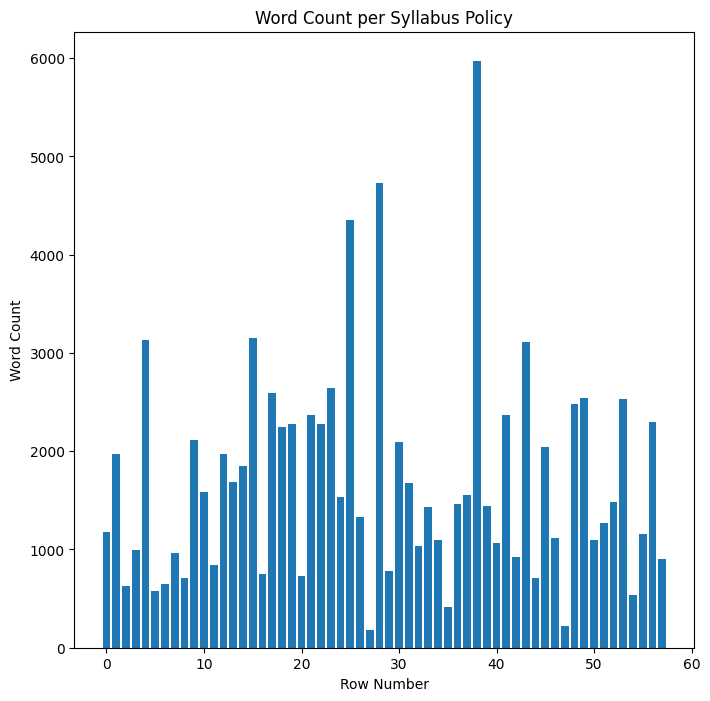

In [12]:
plt.bar(df1.index, df1['word_count'])
plt.xlabel('Row Number')
plt.ylabel('Word Count')
plt.title('Word Count per Syllabus Policy')
plt.show()

In [13]:
# Find policy(ies) with the shortest word count and show brief info/preview
min_wc = df1['word_count'].min()
shortest = df1[df1['word_count'] == min_wc]

# use existing preview() if available, otherwise fallback
if 'preview' in globals() and callable(globals()['preview']):
    _preview = globals()['preview']
else:
    def _preview(text, n=200):
        if not isinstance(text, str):
            return ""
        s = text.replace("\n", " ").strip()
        return s[:n] + ("..." if len(s) > n else "")

name_col = 'Name' if 'Name' in df1.columns else None
fname_col = globals().get('fname_col') if globals().get('fname_col') in df1.columns else ( 'Filename' if 'Filename' in df1.columns else None )

print(f"Minimum word_count = {min_wc}. Found {len(shortest)} policy(ies).\n")

for idx, row in shortest.iterrows():
    print(f"Index: {idx}")
    if name_col:
        print(f"Name: {row.get(name_col)}")
    if fname_col:
        print(f"{fname_col}: {row.get(fname_col)}")
    print(f"word_count: {row.get('word_count')}")
    if 'Policy Text' in row.index:
        print("\nPolicy Text preview:\n")
        print(_preview(row['Policy Text'], n=500))
    else:
        # try other text-like columns
        for col in ['Policy', 'Text', 'file_text']:
            if col in row.index:
                print(f"\n{col} preview:\n")
                print(_preview(row[col], n=500))
                break
    print("\n" + "-"*80)

Minimum word_count = 180. Found 1 policy(ies).

Index: 27
Name: Cardiff University
Filename: 28_cardiff.rtf
word_count: 180

Policy Text preview:

Using Gen AI to support your literature searching Alexis Constantinou("https://sites.cardiff.ac.uk/ilrb/author/sisac14/") 28 November 2024("https://sites.cardiff.ac.uk/ilrb/2024/11/28/")  Welcome to the Library’s guide to using Generative Artificial Intelligence (Gen AI) to support your literature searching. This resource aims to help you understand the benefits and limitations of using generative AI for finding literature to reference in your academic work. Before you use any AI tool to support...

--------------------------------------------------------------------------------


In [14]:
# List policies with word_count under 50
mask = df1['word_count'] < 100
short_policies = df1.loc[mask, ['Name', 'word_count', 'Policy Text']].copy()

def preview(text, n=200):
    if not isinstance(text, str):
        return ""
    s = text.replace("\n", " ").strip()
    return s[:n] + ("..." if len(s) > n else "")

short_policies['preview'] = short_policies['Policy Text'].apply(preview)
short_policies = short_policies.drop(columns=['Policy Text']).reset_index().rename(columns={'index': 'policy_index'})

print(f"Found {len(short_policies)} policies with word_count ", mask)
display(short_policies)

Found 0 policies with word_count  0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47    False
48    False
49    False
50    False
51    False
52    False
53    False
54    False
55    False
56    False
57    False
Name: word_count, dtype: bool


,policy_index,Name,word_count,preview


### Count mentions

In [15]:
# # Function that returns number of hashtags in a string
# def count_hashtags(string):
#     # Split the string into words
#     words = string.split()

#     # Create a list of words that are hashtags
#     hashtags = [word for word in words if word.startswith('#')]

#     # Return number of hashtags
#     return(len(hashtags))

# # Create a feature hashtag_countand display distribution
# df1['hashtag_count'] = df1['content'].apply(count_hashtags)
# df1['hashtag_count'].hist();
# plt.title('Hashtag count distribution');

In [16]:
# # Function that returns number of mentions in a string
# def count_mentions(string):
#     # Split the string into words
#     words = string.split()

#     # Create a list of words that are mentions
#     mentions = [word for word in words if word.startswith('@')]

#     # Return number of mentions
#     return(len(mentions))

# # Create a feature mention_count and display distribution
# df1['mention_count'] = df1['content'].apply(count_mentions)
# df1['mention_count'].hist();
# plt.title('Mention count distribution');

## Readability tests
- Readability test
    - Determine readability of an English passage
    - Scale ranging from primary school up to college graduate level
    - A mathematical formula utilizing word, syllable and sentence count
    - Used in fake news and opinion spam detection
- Examples
    - Flesch reading ease
    - Gunning fog index
    - Simple Measure of Gobbledygook (SMOG)
    - Dale-Chall score
- Flesch reading ease
    - One of the oldest and most widely used tests
    - Dependent on two factors
        - Greater the average sentence length, harder the text is to read
        - Greater the average number of syllables in a word, harder the text is to read
    - Higher the score, greater the readability
- Gunning fog index
    - Developed in 1954
    - Also dependent on average sentence length
    - Greater the percentage of complex words, harder the text is to read
    - Higher the index, lesser the readability


### Readability: Flesch reading ease score 

SOURCE: https://www.plainwords.co.uk/articles/readability_scores.html 

ADD CITATION 


Average reading age in the UK is **nine**
This means that anything written for the public should have a reading score of **90–100**. Mass market newspapers fall into this range.

Broadsheets like The Telegraph or The Guardian aim for scores of 70 to 90, so are readable by 12–13 year olds. A typical best-selling novel can be read by 8–10 year olds.

Check your own readability
To check the readability of your writing using Word's grammar checker, go to Tools–Options–Spelling and Grammar. Make sure that “Show Readability Statistics” is ticked. Then select the text you want to test and select Tools–Spelling and Grammar.

At the end, it'll ask if you want to check the remainder of the document. Click “no” and you'll see the readability statistics.

Here's what the reading ease scores mean:

30 to 40	Very difficult

40 to 50	Difficult

50 to 60	Fairly difficult

60 to 70	Standard

70 to 80	Fairly easy

80 to 90	Very easy


In [17]:
# Compute Flesch Reading Ease score for each policy and save as FREscore
from textatistic import Textatistic

def get_flesch_score(text):
    try:
        return abs(Textatistic(text).scores['flesch_score'])
    except Exception:
        return None

df1['FREscore'] = df1['Policy Text'].apply(get_flesch_score)

print(df1.head())

  Rank                                              Name          Filename  \
0    1  London School of Economics and Political Science        01_LSE.rtf   
1    2                          University of St Andrews  02_stAndrews.pdf   
2    3                                 Durham University     03_Durham.rtf   
3    4                           University of Cambridge  04_cambridge.rtf   
4    5                              University of Oxford     05_oxford.rtf   

                                           PolicyURL  \
0  https://www.lse.ac.uk/anthropology/study/AI-Po...   
1  https://www.st-andrews.ac.uk/policy/academic-p...   
2  https://www.durham.ac.uk/global-durham/global-...   
3  https://www.cambridgeinternational.org/exam-ad...   
4  https://www.ox.ac.uk/research/support-research...   

                                         Policy Text  word_count   FREscore  
0  AI Policy\n\nAI Policy\nAs a student in the De...        1181  50.267196  
1  The University of St Andrews is a c

In [18]:
policies = df1['Policy Text']

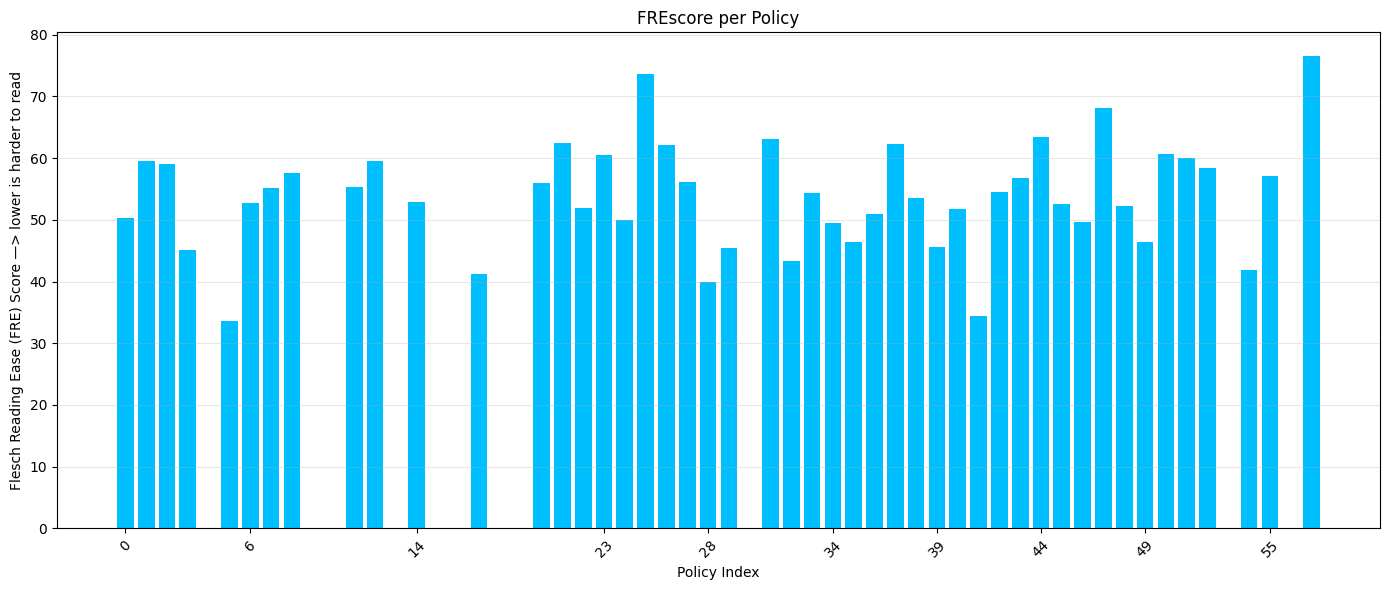

In [19]:
# Bar chart: Flesch Reading Ease (FREscore) for each policy
mask = df1['FREscore'].notnull()
x = df1.index[mask]
y = df1.loc[mask, 'FREscore']

plt.figure(figsize=(14,6))
plt.bar(x, y, color='deepskyblue')
plt.xlabel('Policy Index')
plt.ylabel('Flesch Reading Ease (FRE) Score —> lower is harder to read')
plt.title('FREscore per Policy')
# show fewer x-ticks to avoid clutter
plt.xticks(x[::5], rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### TODO: check why some policies have NAN reading score


plot 6 categories, how many policies in each, mean + variance. 

### gunningfog_score
compute the readability of these excerpts using the Gunning fog index and consequently, determine the relative difficulty of reading these publications.




In [20]:
# List of excerpts


# Compute gunning fog index for each excerpt and add as a new feature
def get_gunning_fog(text):
    try:
        return Textatistic(text).scores['gunningfog_score']
    except Exception:
        return None

df1['gunning_fog_score'] = policies.apply(get_gunning_fog)
# df1['FREscore'] = df1['Policy Text'].apply(get_flesch_score)


# Loop through excerpts and compute gunning fog index
# gunning_fog_scores = []
# for excerpt in excerpts:
#     # Check if excerpt is not empty and contains at least one word
#     if isinstance(excerpt, str) and excerpt.strip() and len(excerpt.split()) > 0:
#         try:
#             readability_scores = Textatistic(excerpt).scores
#             gunning_fog = readability_scores['gunningfog_score']
#         except Exception:
#             gunning_fog = None
#     else:
#         gunning_fog = None
#     gunning_fog_scores.append(gunning_fog)

# # Print the gunning fog indices
# print(gunning_fog_scores)



print(df1.head())

  Rank                                              Name          Filename  \
0    1  London School of Economics and Political Science        01_LSE.rtf   
1    2                          University of St Andrews  02_stAndrews.pdf   
2    3                                 Durham University     03_Durham.rtf   
3    4                           University of Cambridge  04_cambridge.rtf   
4    5                              University of Oxford     05_oxford.rtf   

                                           PolicyURL  \
0  https://www.lse.ac.uk/anthropology/study/AI-Po...   
1  https://www.st-andrews.ac.uk/policy/academic-p...   
2  https://www.durham.ac.uk/global-durham/global-...   
3  https://www.cambridgeinternational.org/exam-ad...   
4  https://www.ox.ac.uk/research/support-research...   

                                         Policy Text  word_count   FREscore  \
0  AI Policy\n\nAI Policy\nAs a student in the De...        1181  50.267196   
1  The University of St Andrews is a

In [21]:
# # Define color mapping based on FREscore ranges
# def fre_color(score):
#     if score < 40:
#         return 'darkred'         # Very difficult
#     elif score < 50:
#         return 'red'             # Difficult
#     elif score < 60:
#         return 'orange'          # Fairly difficult
#     elif score < 70:
#         return 'gold'            # Standard
#     elif score < 80:
#         return 'limegreen'       # Fairly easy
#     else:
#         return 'deepskyblue'     # Very easy

# colors = df1['FREscore'].apply(fre_color)

# plt.bar(df1.index, df1['FREscore'], color=colors)
# plt.xlabel('Row Number')
# plt.ylabel('Flesch Reading Ease Score')
# plt.title('FREscore per Syllabus Policy')
# plt.show()

### Statistics

In [22]:


import re
import statistics

def sentence_length_stats(text):
    # Split text into sentences (basic split by punctuation)
    sentences = re.split(r'[.!?]', text)
    # Remove empty sentences and trim spaces
    sentences = [s.strip() for s in sentences if s.strip()]
    # Count words in each sentence
    word_counts = [len(s.split()) for s in sentences]
    
    if len(word_counts) < 2:
        return {"mean": 0.0, "variance": 0.0, "stdev": 0.0}
    
    return {
        "mean": statistics.mean(word_counts),
        "variance": statistics.variance(word_counts),
        "stdev": statistics.stdev(word_counts)
    }

sentence_stats = policies.apply(sentence_length_stats)

df1['sentenceLen_mean'] = sentence_stats.apply(lambda x: x['mean'])
df1['sentenceLen_var'] = sentence_stats.apply(lambda x: x['variance'])
df1['sentenceLen_stdev'] = sentence_stats.apply(lambda x: x['stdev'])


# print(df1.head())
print(df1[['sentenceLen_mean', 'sentenceLen_var', 'sentenceLen_stdev']].head())

   sentenceLen_mean  sentenceLen_var  sentenceLen_stdev
0         15.610390       173.451470          13.170098
1         14.917293       117.258259          10.828585
2         21.620690        90.386700           9.507192
3         18.035714       316.071429          17.778398
4         12.859922       305.191239          17.469723


map sentence len with FREscore? 
Correlation analysis, between the two. 

Check also the formula of FREscore first. 
Also check other 3 scores. like gunning fog. 

### scispacy - AbbreviationDetector 

In [23]:
import spacy
from scispacy.abbreviation import AbbreviationDetector

nlp = spacy.load("en_core_web_sm")

# Detect number of abbreviations per policy and add as a new feature
def count_abbreviations(text):
	doc = nlp(text)
	return len(doc._.abbreviations)

def get_abbreviation_list(text):
    doc = nlp(text)
    return [abbr.text for abbr in doc._.abbreviations]


nlp.add_pipe("abbreviation_detector")

df1['abbrevationsCount'] = policies.apply(count_abbreviations)
df1['abbreviationsList'] = policies.apply(get_abbreviation_list)

# print(df1[['abbrevationsCount', 'abbreviationsList']].head())

# print(df1.head())





/usr/local/python/3.12.1/lib/python3.12/site-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)
/usr/local/python/3.12.1/lib/python3.12/site-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


In [24]:
# Count policies with undefined abbreviations (abbreviations not defined in text)
def count_undefined_abbreviations(text):
    doc = nlp(text)
    return sum(1 for abbr in doc._.abbreviations if abbr._.long_form is None)

df1['undefinedAbbrevCount'] = policies.apply(count_undefined_abbreviations)
print(df1[['abbrevationsCount', 'undefinedAbbrevCount', 'abbreviationsList']].head())


print(df1[ 'undefinedAbbrevCount'])



/usr/local/python/3.12.1/lib/python3.12/site-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


   abbrevationsCount  undefinedAbbrevCount  \
0                  0                     0   
1                 92                     0   
2                  0                     0   
3                 26                     0   
4                 72                     0   

                                   abbreviationsList  
0                                                 []  
1  [AI, AI, AI, AI, AI, AI, AI, AI, AI, AI, AI, A...  
2                                                 []  
3  [AI, AI, AI, AI, AI, AI, AI, AI, AI, AI, AI, A...  
4  [GenAI, GenAI, GenAI, GenAI, GenAI, GenAI, Gen...  
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
4

### LDA latent dirichlet allocation

### Create Tokens and Vocabulary

Now that we have our books, we need to tokenize the stories by word and then create a vocabulary out of these tokens. sklearn is a fantastic library that we will be using throughout the notebook {cite:p}`sklearn_api`.

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [26]:
# Tokenize each policy separately
words_per_policy = [policy.split() for policy in policies]

# Add as a new feature to df1
df1['wordsList'] = words_per_policy

print(df1[['Policy Text', 'wordsList']].head())
documents = df1['Policy Text'].tolist()
cv = CountVectorizer(stop_words='english')
df = cv.fit_transform(documents)
vocab = cv.get_feature_names_out()

                                         Policy Text  \
0  AI Policy\n\nAI Policy\nAs a student in the De...   
1  The University of St Andrews is a charity regi...   
2  Al in Global Opportunity applications\nIt is u...   
3  The use of generative AI in coursework\n\nThis...   
4  Policy for using Generative AI in Research: gu...   

                                           wordsList  
0  [AI, Policy, AI, Policy, As, a, student, in, t...  
1  [The, University, of, St, Andrews, is, a, char...  
2  [Al, in, Global, Opportunity, applications, It...  
3  [The, use, of, generative, AI, in, coursework,...  
4  [Policy, for, using, Generative, AI, in, Resea...  


Optimal number of LDA topics (clusters) based on silhouette score: 2


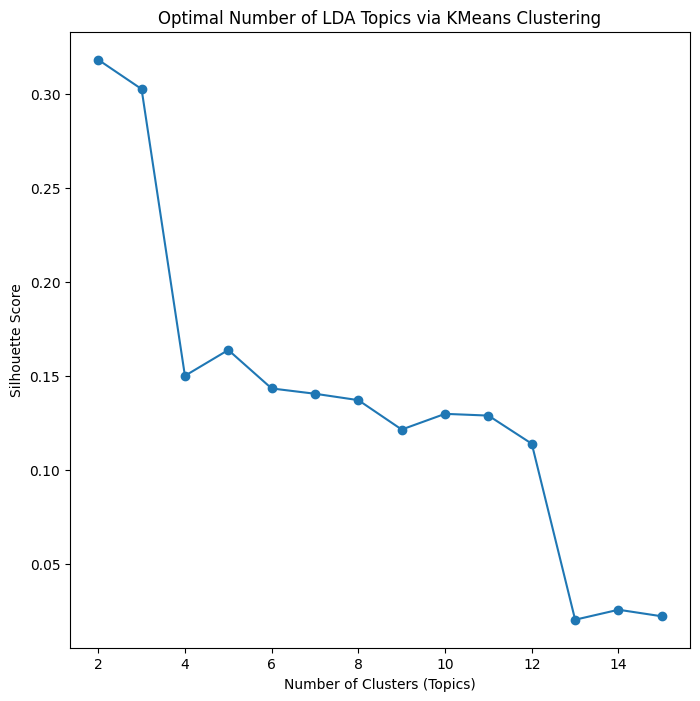

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Use document-term matrix (df) for clustering
max_topics = 15
scores = []
topic_range = range(2, max_topics + 1)


# VECTORISE policies like word2vec before clustering, 
# Try first: sentence embeddings etc. BERT based, any transformer based. 
# apply k-means on the embeddings to find optimal number of clusters (topics) instead of directly on df. 

for k in topic_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(df)
    score = silhouette_score(df, labels)
    scores.append(score)

# Find the optimal number of clusters (topics)
opt_k = topic_range[scores.index(max(scores))]
print(f"Optimal number of LDA topics (clusters) based on silhouette score: {opt_k}")

plt.plot(topic_range, scores, marker='o')
plt.xlabel('Number of Clusters (Topics)')
plt.ylabel('Silhouette Score')
plt.title('Optimal Number of LDA Topics via KMeans Clustering')
plt.show()

In [28]:
# from sklearn.mixture import GaussianMixture
# from sklearn.metrics import silhouette_score

# # Try Gaussian Mixture Model for topic clustering
# bic_scores = []
# sil_scores = []
# max_topics= 12
# topic_range = range(2, max_topics + 1)

# for k in topic_range:
#     gmm = GaussianMixture(n_components=k, random_state=42)
#     labels_gmm = gmm.fit_predict(df.toarray())
#     bic_scores.append(gmm.bic(df.toarray()))
#     sil_scores.append(silhouette_score(df, labels_gmm))

# # Find optimal number of topics by minimum BIC and maximum silhouette score
# opt_k_bic = topic_range[bic_scores.index(min(bic_scores))]
# opt_k_sil = topic_range[sil_scores.index(max(sil_scores))]

# print(f"Optimal number of LDA topics (clusters) via GMM (BIC): {opt_k_bic}")
# print(f"Optimal number of LDA topics (clusters) via GMM (Silhouette): {opt_k_sil}")

# plt.plot(topic_range, bic_scores, marker='o', label='BIC')
# plt.plot(topic_range, sil_scores, marker='x', label='Silhouette')
# plt.xlabel('Number of Clusters (Topics)')
# plt.ylabel('Score')
# plt.title('Optimal Number of LDA Topics via Gaussian Mixture Model')
# plt.legend()
# plt.show()

In [29]:
from sklearn.decomposition import LatentDirichletAllocation
# Fit LDA for each policy (document) individually and store topic distribution
lda = LatentDirichletAllocation(n_components=2, doc_topic_prior=1)
lda_results = lda.fit_transform(df)
lda.fit(df)



,n_components,2
,doc_topic_prior,1
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,10
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


In [30]:
import numpy as np 
topic_words = {}
n_top_words = 10
for topic, comp in enumerate(lda.components_):
    # for the n-dimensional array "arr":
    # argsort() returns a ranked n-dimensional array of arr, call it "ranked_array"
    # which contains the indices that would sort arr in a descending fashion
    # for the ith element in ranked_array, ranked_array[i] represents the index of the
    # element in arr that should be at the ith index in ranked_array
    # ex. arr = [3,7,1,0,3,6]
    # np.argsort(arr) -> [3, 2, 0, 4, 5, 1]
    # word_idx contains the indices in "topic" of the top num_top_words most relevant
    # to a given topic ... it is sorted ascending to begin with and then reversed (desc. now)    
    word_idx = np.argsort(comp)[::-1][:n_top_words]

    # store the words most relevant to the topic
    topic_words[topic] = [vocab[i] for i in word_idx]
    
for topic, words in topic_words.items():
    print('Topic: %d' % topic)
    print('  %s' % ', '.join(words))

Topic: 0
  ai, use, assessment, generative, tools, students, gen, academic, work, learning
Topic: 1
  ai, use, generative, tools, data, academic, work, https, using, uk


In [31]:
# Add topic distribution for each policy as new columns
for i in range(lda_results.shape[1]):
    df1[f'LDA_topic_{i}'] = lda_results[:, i]

print(df1[[f'LDA_topic_{i}' for i in range(lda_results.shape[1])]].head())

   LDA_topic_0  LDA_topic_1
0     0.389378     0.610622
1     0.002192     0.997808
2     0.865099     0.134901
3     0.881426     0.118574
4     0.001179     0.998821


In [32]:
for idx in range(5):
    print(f"LDA topic distribution for policy {idx}:")
    for i in range(lda_results.shape[1]):
        print(f"  Topic {i}: {lda_results[idx, i]:.4f}")
    print()

LDA topic distribution for policy 0:
  Topic 0: 0.3894
  Topic 1: 0.6106

LDA topic distribution for policy 1:
  Topic 0: 0.0022
  Topic 1: 0.9978

LDA topic distribution for policy 2:
  Topic 0: 0.8651
  Topic 1: 0.1349

LDA topic distribution for policy 3:
  Topic 0: 0.8814
  Topic 1: 0.1186

LDA topic distribution for policy 4:
  Topic 0: 0.0012
  Topic 1: 0.9988



Cluster analysis. To see how many clusters we have. 
K-mean. or something with works with text data. 
use number of Clusters, use it as number of topics for LDA, instead of fixing it at 4. 

In [33]:
# from sklearn.decomposition import LatentDirichletAllocation
# lda = LatentDirichletAllocation(n_components = 4, doc_topic_prior=1)
# lda.fit(df)

In [34]:
# import numpy as np 
# topic_words = {}
# n_top_words = 10
# for topic, comp in enumerate(lda.components_):
#     # for the n-dimensional array "arr":
#     # argsort() returns a ranked n-dimensional array of arr, call it "ranked_array"
#     # which contains the indices that would sort arr in a descending fashion
#     # for the ith element in ranked_array, ranked_array[i] represents the index of the
#     # element in arr that should be at the ith index in ranked_array
#     # ex. arr = [3,7,1,0,3,6]
#     # np.argsort(arr) -> [3, 2, 0, 4, 5, 1]
#     # word_idx contains the indices in "topic" of the top num_top_words most relevant
#     # to a given topic ... it is sorted ascending to begin with and then reversed (desc. now)    
#     word_idx = np.argsort(comp)[::-1][:n_top_words]

#     # store the words most relevant to the topic
#     topic_words[topic] = [vocab[i] for i in word_idx]
    
# for topic, words in topic_words.items():
#     print('Topic: %d' % topic)
#     print('  %s' % ', '.join(words))

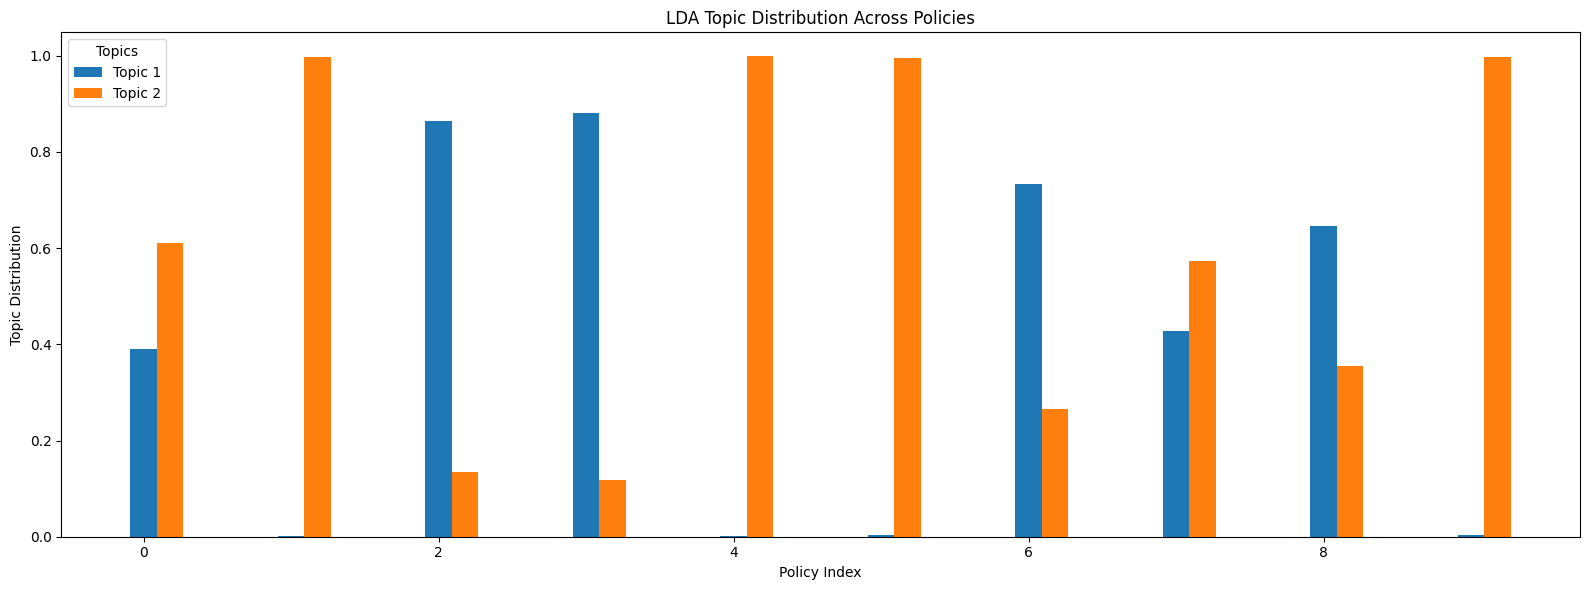

In [35]:
import numpy as np

import matplotlib.pyplot as plt

# Plot bar chart: x-axis = policy indices, grouped by topics (LDA)
num_topics = lda_results.shape[1]
policy_indices = np.arange(lda_results.shape[0])

plt.figure(figsize=(16, 6))
bar_width = 0.18

for topic in range(num_topics):
    plt.bar(policy_indices[:10] + topic * bar_width, lda_results[:10, topic], width=bar_width, label=f'Topic {topic+1}')

plt.xlabel('Policy Index')
plt.ylabel('Topic Distribution')
plt.title('LDA Topic Distribution Across Policies')
plt.legend(title='Topics')
plt.tight_layout()
plt.show()

### LDA - equalise doc length

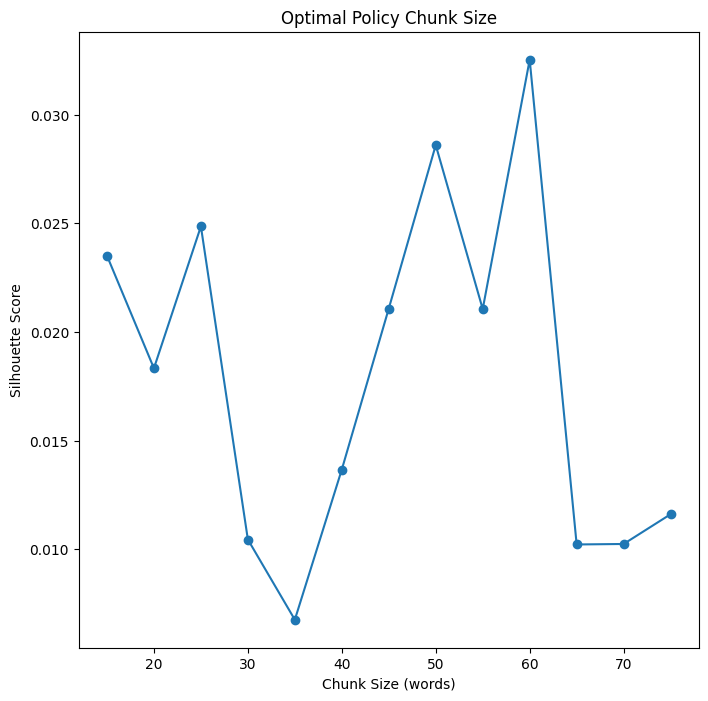

Optimal chunk size based on silhouette score: 60


In [36]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans


def chunk_policy(text, chunk_size):
    words = text.split()
    return [' '.join(words[i:i+chunk_size]) for i in range(0, len(words), chunk_size)]


chunk_sizes = [25, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]
chunk_sizes = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70 ,75]
sil_scores = []

for size in chunk_sizes:
    chunks = []
    for policy in policies:
        chunks.extend(chunk_policy(policy, chunk_size=size))
    cv_tmp = CountVectorizer(stop_words='english', max_df=0.8, min_df=2)
    df_chunks_tmp = cv_tmp.fit_transform(chunks)
    if df_chunks_tmp.shape[0] < 3:
        sil_scores.append(float('nan'))
        continue
    kmeans_tmp = KMeans(n_clusters=4, random_state=42, n_init='auto')
    labels_tmp = kmeans_tmp.fit_predict(df_chunks_tmp)
    score = silhouette_score(df_chunks_tmp, labels_tmp)
    sil_scores.append(score)

plt.plot(chunk_sizes, sil_scores, marker='o')
plt.xlabel('Chunk Size (words)')
plt.ylabel('Silhouette Score')
plt.title('Optimal Policy Chunk Size')
plt.show()

opt_chunk_size = chunk_sizes[sil_scores.index(max(sil_scores))]
print(f"Optimal chunk size based on silhouette score: {opt_chunk_size}")

In [37]:
# Split long policies into chunks of N words (e.g., 50 words per chunk)
# def chunk_policy(text, chunk_size):
#     words = text.split()
#     return [' '.join(words[i:i+chunk_size]) for i in range(0, len(words), chunk_size)]

chunk_size = opt_chunk_size
# Flatten all chunks into a single list
chunks = []
for policy in policies:
    chunks.extend(chunk_policy(policy, chunk_size))

# Filter out overly common/rare terms (e.g., ignore terms in >80% or <2 docs)
cv = CountVectorizer(stop_words='english', max_df=0.8, min_df=2)

# # Filter out overly common/rare terms (e.g., ignore terms in >80% or <2 docs), ignore
# cv = CountVectorizer(
#     stop_words='english',
#     max_df=0.8,
#     min_df=2,
#     token_pattern=r'(?u)\b[a-zA-Z]+\b'
# )


df_chunks = cv.fit_transform(chunks)
vocab_chunks = cv.get_feature_names_out()

print(f"Number of chunks: {len(chunks)}")
print(f"Vocabulary size after filtering: {len(vocab_chunks)}")




Number of chunks: 1674
Vocabulary size after filtering: 3319


Optimal number of LDA topics (clusters) for chunks based on silhouette score: 2


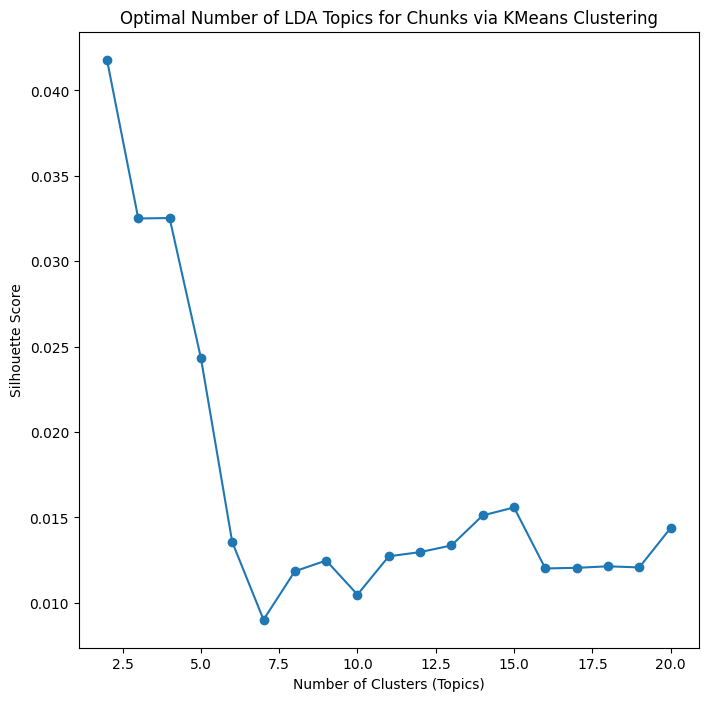

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Use document-term matrix (df_chunks) for clustering
max_topics_chunks = 20
scores_chunks = []
topic_range_chunks = range(2, max_topics_chunks + 1)

for k in topic_range_chunks:
    kmeans_chunks = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels_chunks = kmeans_chunks.fit_predict(df_chunks)
    score_chunks = silhouette_score(df_chunks, labels_chunks)
    scores_chunks.append(score_chunks)

# Find the optimal number of clusters (topics) for chunks
opt_k_chunks = topic_range_chunks[scores_chunks.index(max(scores_chunks))]
print(f"Optimal number of LDA topics (clusters) for chunks based on silhouette score: {opt_k_chunks}")

plt.plot(topic_range_chunks, scores_chunks, marker='o')
plt.xlabel('Number of Clusters (Topics)')
plt.ylabel('Silhouette Score')
plt.title('Optimal Number of LDA Topics for Chunks via KMeans Clustering')
plt.show()

In [39]:
# from sklearn.decomposition import LatentDirichletAllocation
# from sklearn.model_selection import GridSearchCV

# # Use document-term matrix (df_chunks) for LDA topic number selection
# search_params = {'n_components': list(range(2, 21)), 'learning_method': ['batch']}
# lda = LatentDirichletAllocation(random_state=42)
# model = GridSearchCV(lda, param_grid=search_params, cv=3)
# model.fit(df_chunks)

# # Best number of topics
# opt_n_topics = model.best_params_['n_components']
# print(f"Optimal number of LDA topics (chunks) based on GridSearchCV: {opt_n_topics}")

In [40]:
from sklearn.decomposition import LatentDirichletAllocation

# Run LDA on policy chunks
n_topics_chunks = 15
# n_topics_chunks= opt_k_chunks
n_topics_chunks = opt_k_chunks
lda_chunks = LatentDirichletAllocation(
    n_components=n_topics_chunks,
    learning_method='batch',
    random_state=42
)
lda_chunks_results = lda_chunks.fit_transform(df_chunks)

print(f"LDA topic distribution shape for chunks: {lda_chunks_results.shape}")

# Show top words per topic for equalised chunks
n_top_words = 10
vocab_chunks = cv.get_feature_names_out()
for topic_idx, comp in enumerate(lda_chunks.components_):
    word_idx = np.argsort(comp)[::-1][:n_top_words]
    top_words = [vocab_chunks[i] for i in word_idx]
    print(f"Chunk Topic {topic_idx+1}: {', '.join(top_words)}")

LDA topic distribution shape for chunks: (1674, 2)
Chunk Topic 1: ai, tools, data, content, generative, text, use, information, used, chatgpt
Chunk Topic 2: ai, use, generative, assessment, academic, students, work, tools, guidance, https


In [41]:
import pyLDAvis

import pyLDAvis.lda_model

# Prepare pyLDAvis visualization for LDA model (using df and lda from above)
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(lda_chunks, df_chunks, cv)
panel

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.117149  0.0       1        1  60.845961
0     -0.117149  0.0       2        1  39.154039, topic_info=            Term        Freq       Total Category  logprob  loglift
834         data  452.000000  452.000000  Default  30.0000  30.0000
95      academic  601.000000  601.000000  Default  29.0000  29.0000
314   assessment  659.000000  659.000000  Default  28.0000  28.0000
3024        text  239.000000  239.000000  Default  27.0000  27.0000
1441    guidance  393.000000  393.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
3193       using  133.306615  428.924978   Topic2  -5.0900  -0.2310
367    available   70.030518  111.552962   Topic2  -5.7338   0.4721
3292        work  101.492690  592.217292   Topic2  -5.3627  -0.8262
1473        help   72.149651  167.977040   Topic2  -5.7040   0.0926
1763    learning   76.977352  433.124571   Topic2  -5.6392  -0.7898

[154 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
93        1  0.998590           ac
93        2  0.003101           ac
95        1  0.995550     academic
95        2  0.003324     academic
131       1  0.981794  acknowledge
...     ...       ...          ...
3287      2  0.988626         word
3292      1  0.829088         work
3292      2  0.170546         work
3310      1  0.995913          www
3310      2  0.005214          www

[220 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

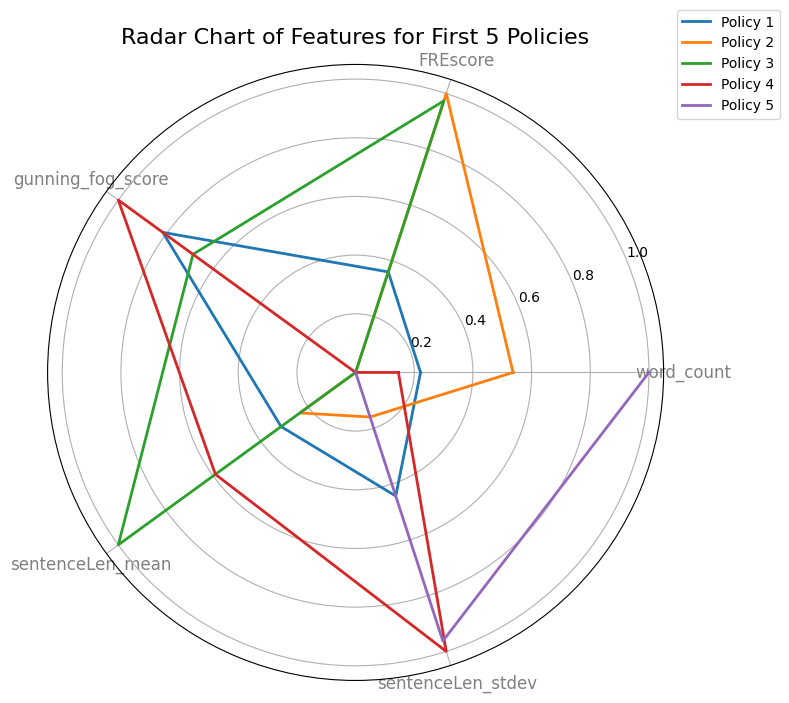

In [42]:
from math import pi
import pandas as pd

import matplotlib.pyplot as plt

# Select first 5 rows and relevant features for radar chart
features = [
    'word_count',
    'FREscore',
    'gunning_fog_score',
    'sentenceLen_mean',
    'sentenceLen_stdev'
]
df_radar = df1.loc[:4, features]

# Normalize features for better visualization
df_norm = (df_radar - df_radar.min()) / (df_radar.max() - df_radar.min())

labels = features
num_vars = len(labels)

angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # Complete the loop

plt.figure(figsize=(8, 8))

for idx, row in df_norm.iterrows():
    values = row.tolist()
    values += values[:1]  # Complete the loop
    plt.polar(angles, values, label=f'Policy {idx+1}', linewidth=2)

plt.xticks(angles[:-1], labels, color='grey', size=12)
plt.title('Radar Chart of Features for First 5 Policies', size=16)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.show()

### CorEx 


In [43]:
from corextopic import corextopic as ct
from sklearn.feature_extraction.text import CountVectorizer

# Prepare document-term matrix (reuse documents from above)
vectorizer = CountVectorizer(stop_words='english')
doc_term_matrix = vectorizer.fit_transform(documents)
words = vectorizer.get_feature_names_out()

# Fit CorEx topic model
n_topics = 5  # You can change this number as needed
corex_model = ct.Corex(n_hidden=n_topics, words=words, seed=42)
# corex_model.fit(doc_term_matrix, words=words)

# Example seed topics (anchor words)
anchors = [
    ["ethics", "ethical", "fair"],               # Topic 1: Ethics
    ["assessment", "exam", "grading", "quiz"],   # Topic 2: Assessment
    ["privacy", "security"],                     # Topic 3: Data Privacy
    ["student", "staff", "faculty"],             # Topic 4: Stakeholders
    ["inclusion", "equity", "accessibility"]   # Topic 5: Inclusivity
]
corex_model.fit(doc_term_matrix, words=words, anchors=anchors, anchor_strength=3)

# Print top words for each topic
for i, topic in enumerate(corex_model.get_topics(n_words=8)):
    print(f"Topic {i+1}: {[w for w, _, _ in topic]}")

Topic 1: ['ethics', 'ethical', 'media', 'novel', 'copy', 'review', 'categories', 'feedback']
Topic 2: ['exam', 'activity', 'cross', 'determine', 'assessments', 'engagement', 'formative', 'viva']
Topic 3: ['privacy', 'security', 'bias', 'personal', 'confidential', 'sections', 'models', 'new']
Topic 4: ['aware', 'important', 'clear', 'staff', 'process', 'expectations', 'member', 'techniques']
Topic 5: ['equity', 'areas', 'normally', 'context', 'shared', 'avoid', 'hand', 'actual']


In [44]:
    
# Get topic distribution for each document
corex_topic_dist = corex_model.transform(doc_term_matrix)

# Add topic distribution to df1
for i in range(n_topics):
    df1[f'CorEx_topic_{i}'] = corex_topic_dist[:, i]

print(df1[[f'CorEx_topic_{i}' for i in range(n_topics)]].head())

   CorEx_topic_0  CorEx_topic_1  CorEx_topic_2  CorEx_topic_3  CorEx_topic_4
0          False           True          False           True          False
1          False           True          False           True          False
2          False          False          False          False          False
3          False          False          False          False           True
4           True          False           True          False          False


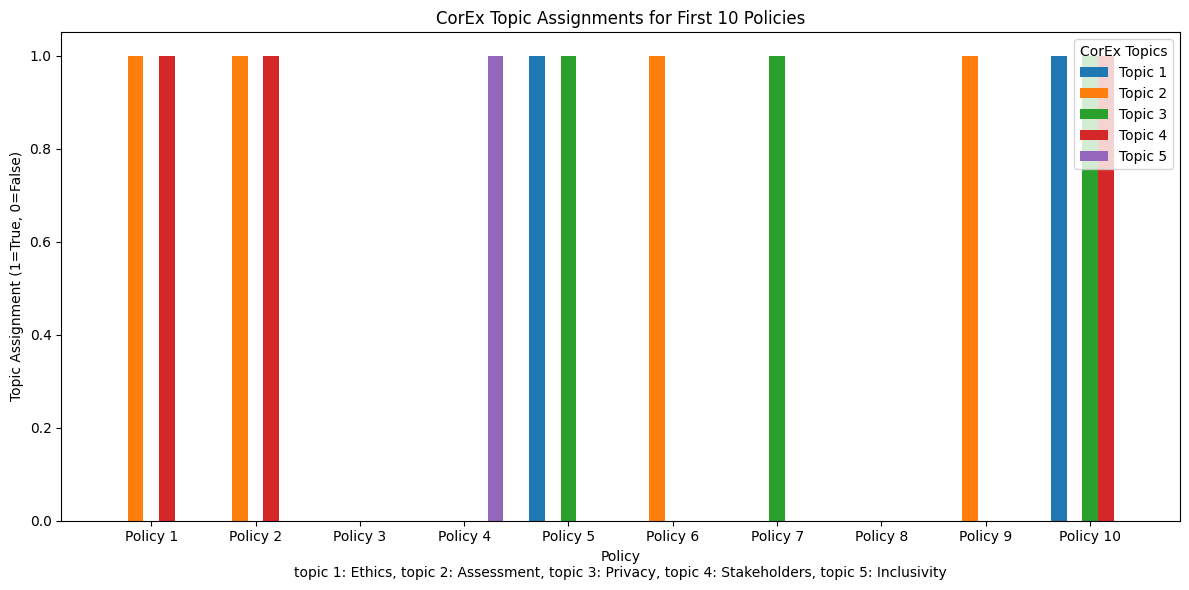

In [45]:
import numpy as np

import matplotlib.pyplot as plt

# Select first 10 policies and their CorEx topic assignments
corex_topics = [f'CorEx_topic_{i}' for i in range(n_topics)]
corex_topic_bool_10 = df1.loc[:9, corex_topics].values.astype(int)

policy_labels_10 = [f'Policy {i+1}' for i in range(10)]
bar_width = 0.15
x = np.arange(10)

plt.figure(figsize=(12, 6))
for topic in range(n_topics):
    plt.bar(x + topic * bar_width, corex_topic_bool_10[:, topic], width=bar_width, label=f'Topic {topic+1}')

plt.xticks(x + bar_width * (n_topics-1)/2, policy_labels_10)
# plt.xlabel('Policy')
plt.ylabel('Topic Assignment (1=True, 0=False)')

# Add topic/anchor names to x-label
anchor_names = [
    "Ethics", "Assessment", "Privacy", "Stakeholders", "Inclusivity"
]
topic_labels = [f"topic {i+1}: {name}" for i, name in enumerate(anchor_names)]
plt.xlabel('Policy\n' + ', '.join(topic_labels))
plt.title('CorEx Topic Assignments for First 10 Policies')
plt.legend(title='CorEx Topics')
plt.tight_layout()
plt.show()

In [46]:
# Add LDA topic distribution as features to df1
for i in range(lda_results.shape[1]):
    df1[f'LDA_topic_{i}'] = lda_results[:, i]

# Add CorEx topic distribution as features to df1
for i in range(n_topics):
    df1[f'CorEx_topic_{i}'] = corex_topic_dist[:, i]

print(df1[[f'LDA_topic_{i}' for i in range(lda_results.shape[1])] + [f'CorEx_topic_{i}' for i in range(n_topics)]].head())

   LDA_topic_0  LDA_topic_1  CorEx_topic_0  CorEx_topic_1  CorEx_topic_2  \
0     0.389378     0.610622          False           True          False   
1     0.002192     0.997808          False           True          False   
2     0.865099     0.134901          False          False          False   
3     0.881426     0.118574          False          False          False   
4     0.001179     0.998821           True          False           True   

   CorEx_topic_3  CorEx_topic_4  
0           True          False  
1           True          False  
2          False          False  
3          False           True  
4          False          False  


### CorEx  - equalised docs


### Selecting the Number of Topics

One way to choose the number of topics is to observe the distribution of TCs for each topic to see how much each additional topic contributes to the overall TC. We should keep adding topics until additional topics do not significantly contribute to the overall TC. This is similar to choosing a cutoff eigenvalue when doing topic modeling via LSA.  https://github.com/gregversteeg/corex_topic/blob/master/corextopic/example/corex_topic_example.ipynb

In [47]:
n_topics = 100
corex_model = ct.Corex(n_hidden=n_topics, words=words, seed=42)
corex_model.fit(doc_term_matrix)

print(corex_model.labels.shape) # n_docs x k_topics

corex_model.tc

corex_model.tcs.shape # k_topics

(58, 100)


(100,)

In [48]:
# Print top words for each topic
for i, topic in enumerate(corex_model.get_topics(n_words=8)):
    print(f"Topic {i+1}: {[w for w, _, _ in topic]}")

NOTE: 'words' not provided to CorEx. Returning topics as lists of column indices
Topic 1: [315, 1860, 3962, 745, 3024, 5239, 4901, 5452]
Topic 2: [4128, 2116, 2018, 2304, 2962, 2023, 3541, 4615]
Topic 3: [1178, 34, 31, 413, 2890, 1692, 1567, 5201]
Topic 4: [4408, 2863, 3716, 2840, 2614, 1050, 3000, 4176]
Topic 5: [1445, 1939, 4036, 2669, 517, 4769, 5100, 5165]
Topic 6: [1219, 2500, 2311, 328, 4352, 1331, 903, 1295]
Topic 7: [4084, 305, 1867, 1257, 2498, 4709, 4678, 1470]
Topic 8: [4750, 5292, 2305, 1594, 3355, 1423, 1532, 3866]
Topic 9: [3561, 1186, 2509, 4477, 3314, 2876, 5473, 4232]
Topic 10: [1519, 114, 4845, 263, 1755, 5240, 1660, 4501]
Topic 11: [4065, 330, 3952, 1485, 2065, 5099, 3894, 4384]
Topic 12: [1024, 5376, 2886, 3822, 3275, 5691, 4057, 1056]
Topic 13: [3398, 5182, 4400, 4663, 1778, 5076, 535, 405]
Topic 14: [4115, 3153, 431, 4068, 5475, 1491, 4004, 4534]
Topic 15: [2465, 961, 1897, 2820, 594, 3803, 2706, 4315]
Topic 16: [2975, 3662, 3518, 1643, 1285, 1176, 3927, 4812]
Top

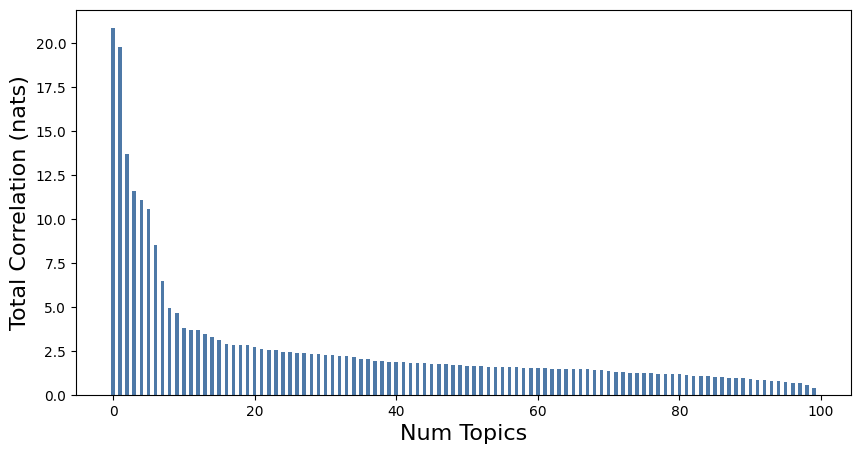

In [49]:
plt.figure(figsize=(10,5))
plt.bar(range(corex_model.tcs.shape[0]), corex_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Num Topics', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

### semi supervised CorEx

In [50]:
# Print lengths (characters and words) for all policies using existing `policies` Series
lengths_df = pd.DataFrame({
    'policy_index': policies.index,
    'char_length': policies.apply(lambda x: len(x) if isinstance(x, str) else 0),
    'word_count': policies.apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
}).set_index('policy_index')

print(lengths_df)

              char_length  word_count
policy_index                         
0                    7963        1181
1                   12201        1972
2                    3773         626
3                    6872         992
4                   24668        3133
5                    4875         578
6                    4914         647
7                    6189         967
8                    5104         708
9                   15102        2118
10                   9956        1582
11                   5661         847
12                  12201        1972
13                  11368        1691
14                  12642        1853
15                  21825        3156
16                   6035         750
17                  16735        2594
18                  15831        2246
19                  16698        2273
20                   4684         729
21                  14564        2373
22                  14474        2277
23                  16662        2643
24          

In [94]:
# List policies with word count smaller than opt_chunk_size
small = lengths_df[lengths_df['word_count'] < opt_chunk_size].copy()

print(f"Policies with word_count < {opt_chunk_size}: {len(small)}\n")

# Add a short preview of the policy text for quick inspection
def preview_text(i, nchars=200):
    txt = df1.loc[i, 'Policy Text']
    if not isinstance(txt, str):
        return ""
    return txt.replace("\n", " ")[:nchars] + ("..." if len(txt) > nchars else "")

small['preview'] = [preview_text(i) for i in small.index]

# Show index, word_count, char_length and preview
display_cols = ['word_count', 'char_length', 'preview']
print(small[display_cols].to_string())

Policies with word_count < 60: 0

Empty DataFrame
Columns: [word_count, char_length, preview]
Index: []


In [95]:
from corextopic import corextopic as ct
from sklearn.feature_extraction.text import CountVectorizer

# # Prepare document-term matrix (reuse documents from above)
# vectorizer = CountVectorizer(stop_words='english')
# doc_term_matrix = vectorizer.fit_transform(documents)
# words = vectorizer.get_feature_names_out()


# Split policies into equal-length chunks (e.g., 50 words)
chunk_size=opt_chunk_size
print(f"Using chunk size = {chunk_size} words")
# chunk_size=100 --- IGNORE ---


def chunk_policy(text, chunk_size):
    words = text.split()
    return [' '.join(words[i:i+chunk_size]) for i in range(0, len(words), chunk_size)]

chunks = []
for policy in policies:
    chunks.extend(chunk_policy(policy, chunk_size))

# Prepare document-term matrix for chunks
vectorizer = CountVectorizer(stop_words='english')
doc_term_matrix = vectorizer.fit_transform(chunks)
words = vectorizer.get_feature_names_out()

Using chunk size = 60 words


In [103]:

# anchors = [
#     ["ethics", "ethical", "fair"],
#     ["assessment", "exam", "grading", "quiz"],
#     ["privacy", "security"],
#     ["student", "staff", "faculty"],
#     # ["inclusion", "equity", "accessibility"]
# ]
# alex's 3 discourses:
# --Usability as adoption readiness, professional development
# --Fairness as compliance and ethical, risk, biases, marginalisation 
# --Effectiveness as Measurable Performance, facilitate teaching

anchors_old = [
    ["ethics", "ethical", "fair"],               # Topic 1: Ethics
    ["assessment", "exam", "grading", "quiz"],   # Topic 2: Assessment
    ["privacy", "security"],                     # Topic 3: Data Privacy
    ["student", "staff", "faculty"],             # Topic 4: Stakeholders
    ["inclusion", "equity", "accessibility"]   # Topic 5: Inclusivity
]

alexes_3_discourses = [
    ["Usability", "adoption", "readiness", "development"],
    ["Fair", "compliance", "ethical", "risk", "biases", "marginalise"],
    ["Effective", "Measure", "Performance", "facilitate", "teaching"]
    # ["student", "staff", "faculty"],
    # ["inclusion", "equity", "accessibility"]
]

topics_from_thematic_analysis = [
    ["resources", "training",],
    ["disability", "accessible"],
    ["acknowledge", "cite", "reference"],
    ["appropriate", "allowed", "ethical", "transparency", "use", "integrity"],
    ["risk", "privacy", "error", "inaccurate", "hallucination", "copyright" ],
    ["misconduct"],
    ["detection", "plagiarism"]
]



# • resources and training
# • references
# • policyReview
# • policy
# • uses
# • toolDetails
# • summary
# • defination


# • support4staff
# • staffguidence
# • people
# • left2staff


# • strateges


# • appropriateUse
# • transparency

# • unallowedUse
# • risks
# • retention
# • restriction
# • dataUpload
# • integrity
# • copyright
# • enviorment
# • english
# • dependency

# • diablity and accessiblity

# • ai detection

# • misconduct

# • acknowledge


In [97]:
print(len(anchors))

7


In [105]:



# Fit CorEx topic model on equalised chunks
# n_topics = 20
# n_topics = 3
n_topics = len(anchors)+1
# n_topics=14
corex_model = ct.Corex(n_hidden=n_topics, words=words, seed=42)




# anchors = anchors_old
# anchors = alexes_3_discourses 
anchors = topics_from_thematic_analysis

corex_model.fit(doc_term_matrix, words=words, anchors=anchors, anchor_strength=5)
# corex_model.fit(doc_term_matrix, words=words)

# Print top words for each topic
for i, topic in enumerate(corex_model.get_topics(n_words=10)):
    print(f"Topic {i+1}: {[w for w, _, _ in topic]}")


Topic 1: ['resources', 'training', 'library', 'work', 'science', 'sussex', 'oxford', 'access', 'centre', 'journals']
Topic 2: ['accessible', 'disability', 'summarising', 'problem', 'solving', 'generating', 'revision', 'visual', 'tasks', 'based']
Topic 3: ['reference', 'acknowledge', 'cite', 'referencing', 'list', 'citation', 'harvard', 'learning', 'march', 'citethemrightonline']
Topic 4: ['use', 'appropriate', 'allowed', 'ethical', 'ai', 'assessment', 'permitted', 'responsible', 'inappropriate', 'clearly']
Topic 5: ['copyright', 'privacy', 'risk', 'inaccurate', 'data', 'protection', 'personal', 'property', 'intellectual', 'sensitive']
Topic 6: ['misconduct', 'academic', 'ac', 'uk', 'regulations', 'https', 'procedure', 'www', 'policy', 'considered']
Topic 7: ['plagiarism', 'detection', 'charity', 'adjustment', 'sc013532', 'scotland', '14', 'andrews', 'disabled', 'registered']
Topic 8: ['language', 'copilot', 'microsoft', 'models', 'large', 'intelligence', 'module', 'artificial', 'google

In [107]:
# Get topic distribution for each chunk
corex_topic_dist = corex_model.transform(doc_term_matrix)

# Aggregate chunk-level topic assignments to policy-level by mean
chunks_per_policy = [len(chunk_policy(policy, chunk_size)) for policy in policies]
chunk_indices = np.repeat(np.arange(len(policies)), chunks_per_policy)

# Create a DataFrame for chunk topic assignments
corex_chunk_df = pd.DataFrame(corex_topic_dist, columns=[f'CorEx_topic_{i}' for i in range(n_topics)])
corex_chunk_df['policy_idx'] = chunk_indices

# Compute mean topic assignment for each policy
corex_policy_topic_means = corex_chunk_df.groupby('policy_idx').mean()

# Add topic distribution to df1
for i in range(n_topics):
    df1[f'CorEx_topic_{i}'] = corex_policy_topic_means[f'CorEx_topic_{i}'].values

print(df1[[f'CorEx_topic_{i}' for i in range(n_topics)]].head())

   CorEx_topic_0  CorEx_topic_1  CorEx_topic_2  CorEx_topic_3  CorEx_topic_4  \
0       0.200000       0.200000       0.050000       0.650000       0.200000   
1       0.060606       0.272727       0.060606       0.575758       0.090909   
2       0.090909       0.000000       0.090909       0.454545       0.090909   
3       0.117647       0.058824       0.117647       0.764706       0.117647   
4       0.566038       0.132075       0.132075       0.584906       0.339623   

   CorEx_topic_5  CorEx_topic_6  CorEx_topic_7  
0       0.250000       0.100000       0.400000  
1       0.090909       0.303030       0.151515  
2       0.000000       0.545455       0.454545  
3       0.058824       0.588235       0.411765  
4       0.075472       0.094340       0.905660  


In [ ]:
# Find policies with no CorEx topics assigned (all zeros)
corex_topics = [f'CorEx_topic_{i}' for i in range(n_topics)]
no_topic_policies = df1.index[(df1[corex_topics].sum(axis=1) == 0)].tolist()

print("Policies with no topics assigned:", no_topic_policies)

Policies with no topics assigned: []


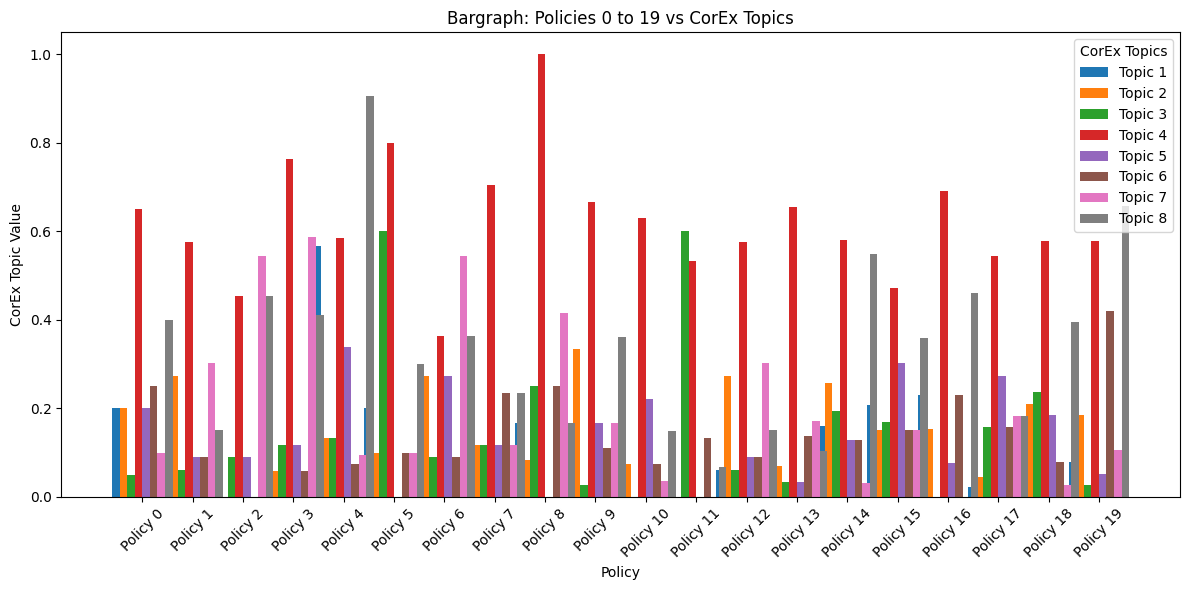

In [109]:

import numpy as np
import matplotlib.pyplot as plt

# Show policies 0 to 19 (indices 0 to 19)
start_idx = 0
num2show = 20
end_idx = start_idx + num2show - 1

corex_topics = [f'CorEx_topic_{i}' for i in range(n_topics)]
corex_topic_vals = df1.loc[start_idx:end_idx, corex_topics].values

policy_labels = [f'Policy {i}' for i in range(start_idx, end_idx+1)]
bar_width = 0.15
x = np.arange(num2show)

plt.figure(figsize=(12, 6))
for topic in range(n_topics):
    plt.bar(x + topic * bar_width, corex_topic_vals[:, topic], width=bar_width, label=f'Topic {topic+1}')

plt.xticks(x + bar_width * (n_topics-1)/2, policy_labels, rotation=45)
plt.ylabel('CorEx Topic Value')
plt.xlabel('Policy')
plt.title('Bargraph: Policies 0 to 19 vs CorEx Topics')
plt.legend(title='CorEx Topics')
plt.tight_layout()
plt.show()


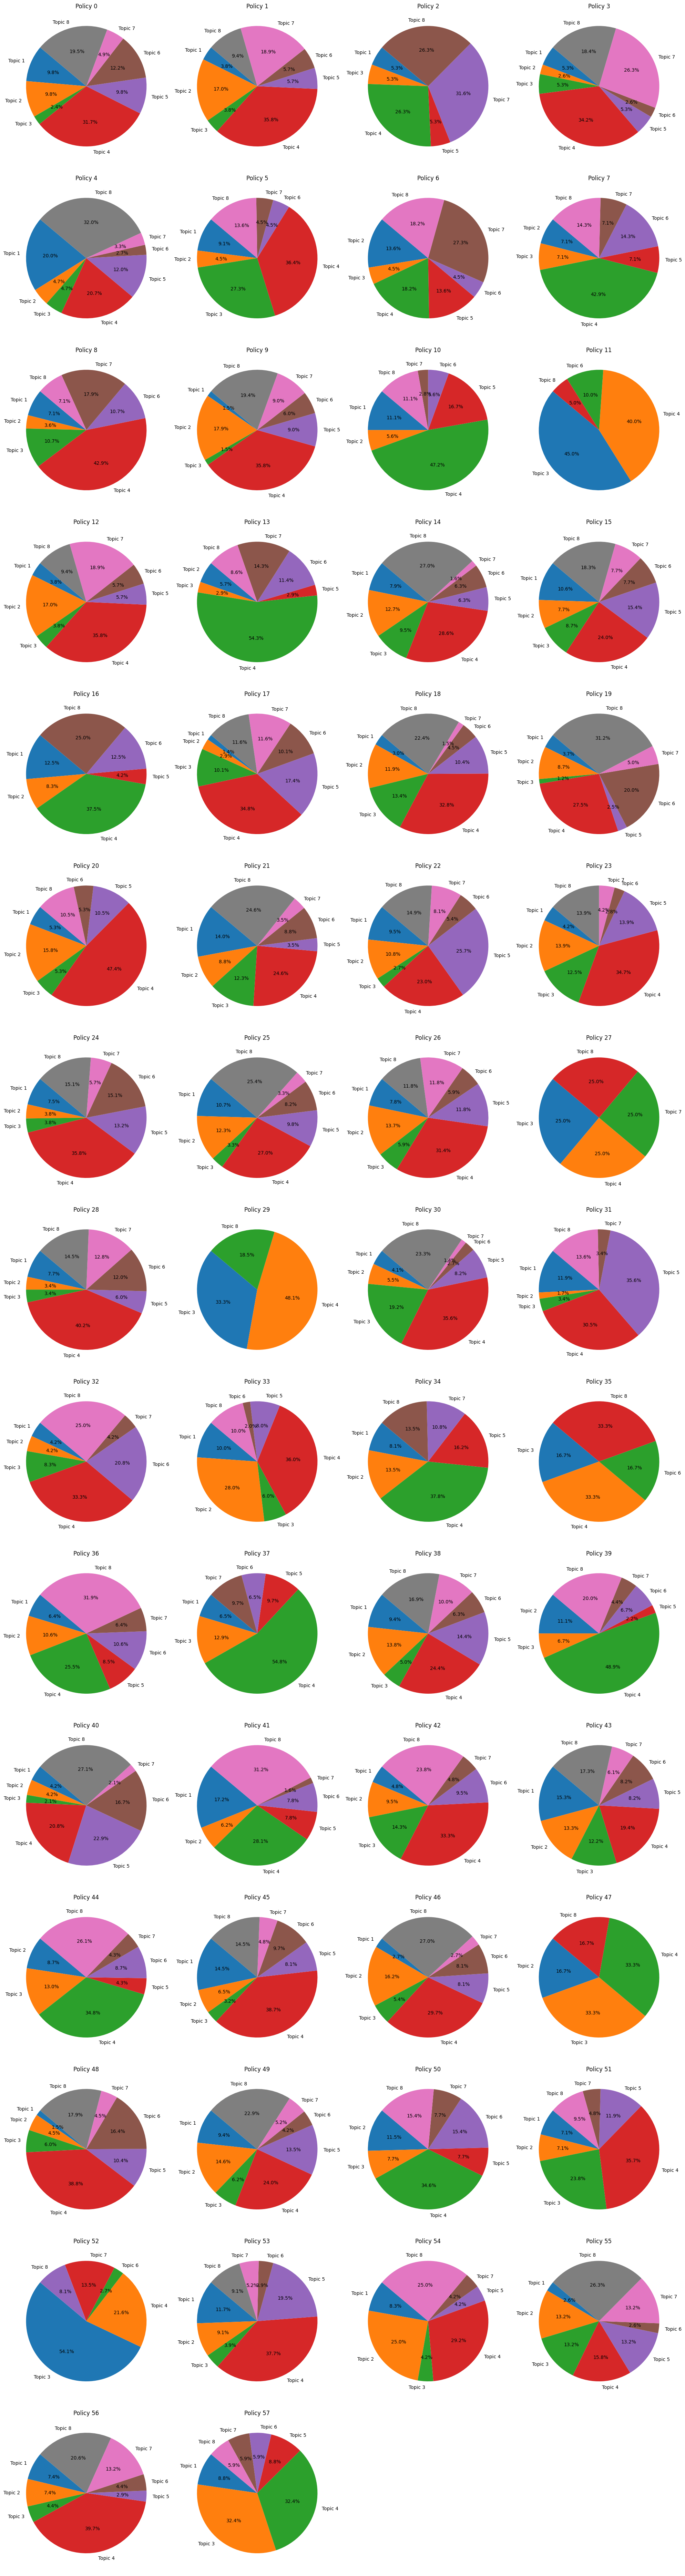

In [110]:
import numpy as np

import matplotlib.pyplot as plt

corex_topics = [f'CorEx_topic_{i}' for i in range(n_topics)]
num_policies = len(df1)
start_idx = 0
end_idx = start_idx + num_policies - 1

num_cols = 4
num_rows = (num_policies + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))

labels_all = [f'Topic {i+1}' for i in range(n_topics)]

plot_idx = 0
for idx in range(start_idx, end_idx + 1):
    # safe cast to numeric array
    topic_values = np.array(df1.loc[idx, corex_topics].values, dtype=float)
    row = plot_idx // num_cols
    col = plot_idx % num_cols
    ax = axes[row, col]

    if topic_values.sum() == 0:
        # draw a single-slice grey pie for policies with no topic assignment
        ax.pie([1], colors=['lightgrey'], labels=[''], startangle=140, autopct='%1.1f%%')
        ax.set_title(f'Policy {idx} (No Matching Topics Found)')
    else:
        # filter out zero-value topics to avoid tiny/empty slices and label topics starting at 1
        mask = topic_values > 0
        vals = topic_values[mask]
        labs = [labels_all[i] for i, m in enumerate(mask) if m]
        ax.pie(vals, labels=labs, autopct='%1.1f%%', startangle=140)
        ax.set_title(f'Policy {idx}')
    plot_idx += 1

# Hide unused subplots
for i in range(plot_idx, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


### find optimum number of topics, for CorEx

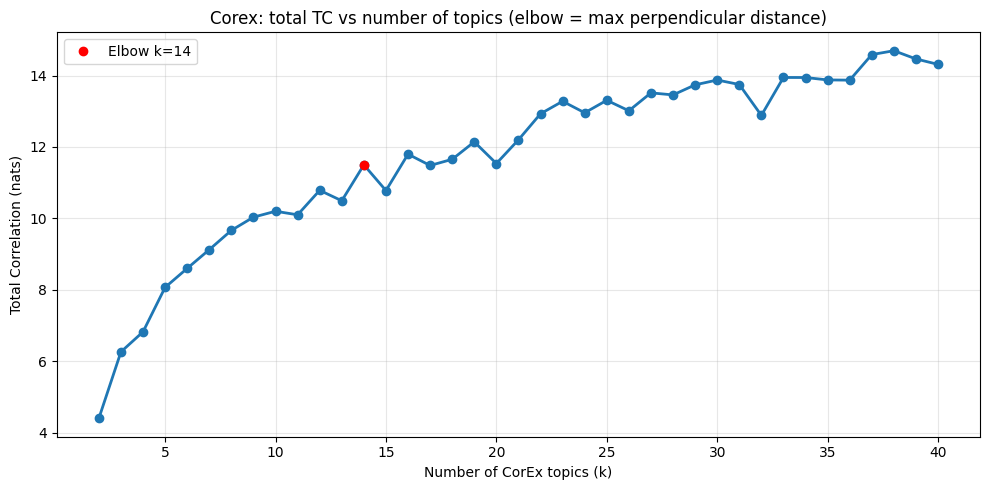

Checked k in [2,40]. Detected elbow at k = 14.

Top rows of results:
 k  total_tc
 2  4.403212
 3  6.264069
 4  6.825333
 5  8.069946
 6  8.601464
 7  9.125966
 8  9.665998
 9 10.035658
10 10.200648
11 10.101605


In [90]:
import numpy as np
from corextopic import corextopic as ct
import pandas as pd

# Corex: search optimal number of topics (k) using Total Correlation (TC) / elbow method
# Relies on existing `doc_term_matrix` and `words` (vocabulary) in the notebook.
import matplotlib.pyplot as plt

if 'doc_term_matrix' not in globals() or 'words' not in globals():
    raise RuntimeError("Please ensure `doc_term_matrix` and `words` exist in the notebook globals.")

# Candidate range for number of topics
min_k = 2
max_k = min(40, max(5, doc_term_matrix.shape[0] // 2))  # avoid overly large k
ks = list(range(min_k, max_k + 1))

tcs_total = []
per_topic_tcs = []

for k in ks:
    model = ct.Corex(n_hidden=k, words=words, seed=42)
    # fit can be slower for large k; keep verbose off by default
    model.fit(doc_term_matrix)
    # model.tc is total correlation explained; fallback to sum(model.tcs) if needed
    tc_val = float(getattr(model, "tc", np.sum(getattr(model, "tcs", np.array([0.0])))))
    tcs_total.append(tc_val)
    per_topic_tcs.append(list(getattr(model, "tcs", np.zeros(k))))
    # store last fitted model in case user wants to inspect it
    globals()[f'corex_model_k_{k}'] = model

# convert to DataFrame for inspection
df_corex_search = pd.DataFrame({
    'k': ks,
    'total_tc': tcs_total
})

# elbow detection: max distance from line between first and last point
x = np.array(df_corex_search['k'], dtype=float)
y = np.array(df_corex_search['total_tc'], dtype=float)
x1, y1 = x[0], y[0]
x2, y2 = x[-1], y[-1]
num = np.abs((y2 - y1) * x - (x2 - x1) * y + x2 * y1 - y2 * x1)
den = np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)
distances = num / (den + 1e-12)
elbow_idx = int(np.argmax(distances))
elbow_k = int(x[elbow_idx])

# Also compute marginal gains to help decision
marginal = np.diff(y)
rel_marginal = marginal / (y[:-1] + 1e-12)

# Save results to globals for later inspection
globals()['df_corex_k_search'] = df_corex_search
globals()['corex_search_per_topic_tcs'] = per_topic_tcs
globals()['corex_search_elbow_k'] = elbow_k
globals()['corex_search_marginal'] = marginal
globals()['corex_search_rel_marginal'] = rel_marginal

# Plot results and mark elbow
plt.figure(figsize=(10,5))
plt.plot(ks, tcs_total, marker='o', linewidth=2)
plt.plot(elbow_k, df_corex_search.loc[df_corex_search['k'] == elbow_k, 'total_tc'].values[0],
         'ro', label=f'Elbow k={elbow_k}')
plt.xlabel('Number of CorEx topics (k)')
plt.ylabel('Total Correlation (nats)')
plt.title('Corex: total TC vs number of topics (elbow = max perpendicular distance)')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print concise summary
print(f"Checked k in [{min_k},{max_k}]. Detected elbow at k = {elbow_k}.")
print("\nTop rows of results:")
print(df_corex_search.head(10).to_string(index=False))

In [ ]:

# anchors = [
#     ["ethics", "ethical", "fair"],
#     ["assessment", "exam", "grading", "quiz"],
#     ["privacy", "security"],
#     ["student", "staff", "faculty"],
#     # ["inclusion", "equity", "accessibility"]
# ]
# alex's 3 discourses:
# --Usability as adoption readiness, professional development
# --Fairness as compliance and ethical, risk, biases, marginalisation 
# --Effectiveness as Measurable Performance, facilitate teaching

anchors_old = [
    ["ethics", "ethical", "fair"],               # Topic 1: Ethics
    ["assessment", "exam", "grading", "quiz"],   # Topic 2: Assessment
    ["privacy", "security"],                     # Topic 3: Data Privacy
    ["student", "staff", "faculty"],             # Topic 4: Stakeholders
    ["inclusion", "equity", "accessibility"]   # Topic 5: Inclusivity
]

alexes_3_discourses = [
    ["Usability", "adoption", "readiness", "development"],
    ["Fair", "compliance", "ethical", "risk", "biases", "marginalise"],
    ["Effective", "Measure", "Performance", "facilitate", "teaching"]
    # ["student", "staff", "faculty"],
    # ["inclusion", "equity", "accessibility"]
]

topics_from_thematic_analysis = [
    ["resources", "training",],
    ["disability", "accessible"],
    ["acknowledge", "cite", "reference"],
    ["appropriate", "allowed", "ethical", "transparency", "use", "integrity"],
    ["risk", "privacy", "error", "inaccurate", "hallucination", "copyright" ],
    ["misconduct"],
    ["detection", "plagiarism"]
]



# • resources and training
# • references
# • policyReview
# • policy
# • uses
# • toolDetails
# • summary
# • defination


# • support4staff
# • staffguidence
# • people
# • left2staff


# • strateges


# • appropriateUse
# • transparency

# • unallowedUse
# • risks
# • retention
# • restriction
# • dataUpload
# • integrity
# • copyright
# • enviorment
# • english
# • dependency

# • diablity and accessiblity

# • ai detection

# • misconduct

# • acknowledge


In [113]:



# Fit CorEx topic model on equalised chunks
# n_topics = 20
# n_topics = 3
# n_topics = len(anchors)+1
n_topics=elbow_k
corex_model = ct.Corex(n_hidden=n_topics, words=words, seed=42)




# anchors = anchors_old
# anchors = alexes_3_discourses 
anchors = topics_from_thematic_analysis
# anchors=[]

corex_model.fit(doc_term_matrix, words=words, anchors=anchors, anchor_strength=5)
# corex_model.fit(doc_term_matrix, words=words)

# Print top words for each topic
for i, topic in enumerate(corex_model.get_topics(n_words=10)):
    print(f"Topic {i+1}: {[w for w, _, _ in topic]}")


Topic 1: ['resources', 'training', 'models', 'library', 'qmul', 'lib', 'bham', 'incorporating', 'workshops', 'canvas']
Topic 2: ['accessible', 'disability', 'bristol', 'adjustment', 'speech', 'disabled', 'recognising', 'kcl', 'ensures', 'spoken']
Topic 3: ['reference', 'acknowledge', 'cite', 'referencing', 'com', 'harvard', 'citation', 'citethemrightonline', 'list', 'right']
Topic 4: ['use', 'appropriate', 'allowed', 'ethical', 'ai', 'responsible', 'clearly', 'responsibly', 'generates', 'regarding']
Topic 5: ['copyright', 'privacy', 'risk', 'inaccurate', 'data', 'personal', 'property', 'protection', 'intellectual', 'sensitive']
Topic 6: ['misconduct', 'academic', 'ac', 'uk', 'regulations', 'https', 'procedure', 'considered', 'policy', 'www']
Topic 7: ['plagiarism', 'detection', 'andrews', 'charity', 'sc013532', 'aspx', 'contract', 'birmingham', 'scotland', 'st']
Topic 8: ['skills', 'critical', 'thinking', 'knowledge', 'develop', 'understanding', 'developing', 'trained', 'based', 'biase

In [114]:
# Get topic distribution for each chunk
corex_topic_dist = corex_model.transform(doc_term_matrix)

# Aggregate chunk-level topic assignments to policy-level by mean
chunks_per_policy = [len(chunk_policy(policy, chunk_size)) for policy in policies]
chunk_indices = np.repeat(np.arange(len(policies)), chunks_per_policy)

# Create a DataFrame for chunk topic assignments
corex_chunk_df = pd.DataFrame(corex_topic_dist, columns=[f'CorEx_topic_{i}' for i in range(n_topics)])
corex_chunk_df['policy_idx'] = chunk_indices

# Compute mean topic assignment for each policy
corex_policy_topic_means = corex_chunk_df.groupby('policy_idx').mean()

# Add topic distribution to df1
for i in range(n_topics):
    df1[f'CorEx_topic_{i}'] = corex_policy_topic_means[f'CorEx_topic_{i}'].values

print(df1[[f'CorEx_topic_{i}' for i in range(n_topics)]].head())

   CorEx_topic_0  CorEx_topic_1  CorEx_topic_2  CorEx_topic_3  CorEx_topic_4  \
0       0.150000       0.150000       0.000000       0.650000       0.150000   
1       0.090909       0.212121       0.090909       0.575758       0.090909   
2       0.000000       0.181818       0.090909       0.454545       0.272727   
3       0.117647       0.117647       0.176471       0.764706       0.000000   
4       0.358491       0.132075       0.113208       0.584906       0.301887   

   CorEx_topic_5  CorEx_topic_6  CorEx_topic_7  CorEx_topic_8  CorEx_topic_9  \
0       0.300000       0.150000       0.250000       0.750000       0.150000   
1       0.121212       0.333333       0.212121       0.696970       0.212121   
2       0.090909       0.272727       0.000000       0.636364       0.000000   
3       0.000000       0.470588       0.117647       0.705882       0.235294   
4       0.113208       0.207547       0.226415       0.773585       0.528302   

   CorEx_topic_10  CorEx_topic_11  Cor

In [115]:
# Find policies with no CorEx topics assigned (all zeros)
corex_topics = [f'CorEx_topic_{i}' for i in range(n_topics)]
no_topic_policies = df1.index[(df1[corex_topics].sum(axis=1) == 0)].tolist()

print("Policies with no topics assigned:", no_topic_policies)

Policies with no topics assigned: []


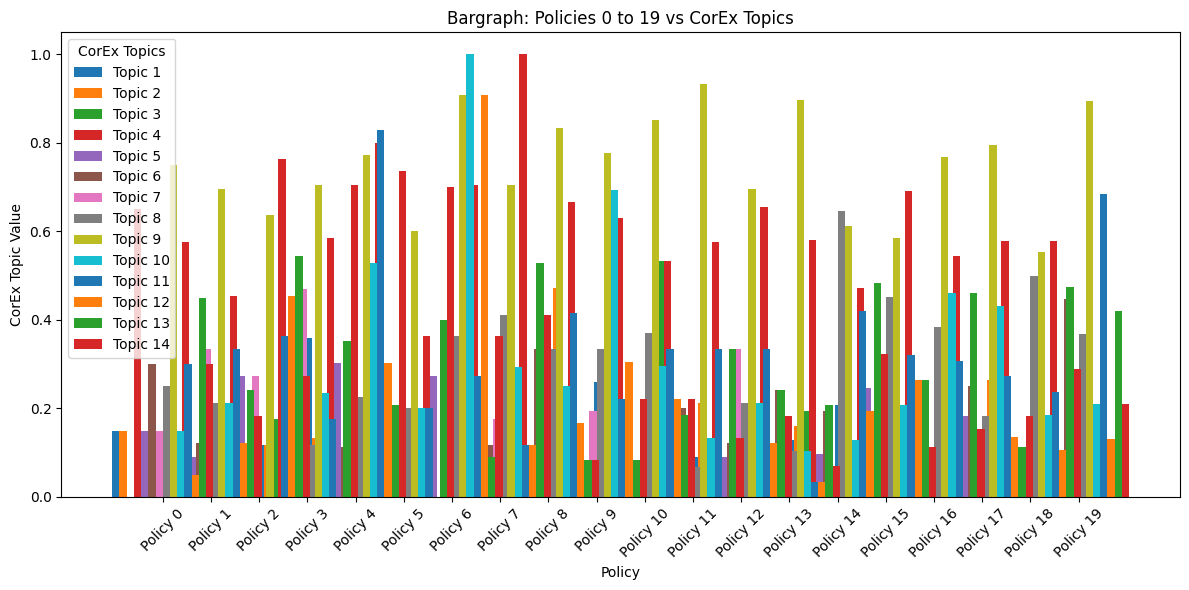

In [116]:


import numpy as np
import matplotlib.pyplot as plt

# Show policies 0 to 19 (indices 0 to 19)
start_idx = 0
num2show = 20
end_idx = start_idx + num2show - 1

corex_topics = [f'CorEx_topic_{i}' for i in range(n_topics)]
corex_topic_vals = df1.loc[start_idx:end_idx, corex_topics].values

policy_labels = [f'Policy {i}' for i in range(start_idx, end_idx+1)]
bar_width = 0.15
x = np.arange(num2show)

plt.figure(figsize=(12, 6))
for topic in range(n_topics):
    plt.bar(x + topic * bar_width, corex_topic_vals[:, topic], width=bar_width, label=f'Topic {topic+1}')

plt.xticks(x + bar_width * (n_topics-1)/2, policy_labels, rotation=45)
plt.ylabel('CorEx Topic Value')
plt.xlabel('Policy')
plt.title('Bargraph: Policies 0 to 19 vs CorEx Topics')
plt.legend(title='CorEx Topics')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

import matplotlib.pyplot as plt

corex_topics = [f'CorEx_topic_{i}' for i in range(n_topics)]
num_policies = len(df1)
start_idx = 0
end_idx = start_idx + num_policies - 1

num_cols = 4
num_rows = (num_policies + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))

labels_all = [f'Topic {i+1}' for i in range(n_topics)]

plot_idx = 0
for idx in range(start_idx, end_idx + 1):
    # safe cast to numeric array
    topic_values = np.array(df1.loc[idx, corex_topics].values, dtype=float)
    row = plot_idx // num_cols
    col = plot_idx % num_cols
    ax = axes[row, col]

    if topic_values.sum() == 0:
        # draw a single-slice grey pie for policies with no topic assignment
        ax.pie([1], colors=['lightgrey'], labels=[''], startangle=140, autopct='%1.1f%%')
        ax.set_title(f'Policy {idx} (No Matching Topics Found)')
    else:
        # filter out zero-value topics to avoid tiny/empty slices and label topics starting at 1
        mask = topic_values > 0
        vals = topic_values[mask]
        labs = [labels_all[i] for i, m in enumerate(mask) if m]
        ax.pie(vals, labels=labs, autopct='%1.1f%%', startangle=140)
        ax.set_title(f'Policy {idx}')
    plot_idx += 1

# Hide unused subplots
for i in range(plot_idx, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


### individual policy report

Policy index: 23

Full policy text:

('Code of conduct\n'
 'Use of generative artificial intelligence for students\n'
 'Guidelines for the appropriate use and acknowledgement of generative '
 'artificial intelligence (GAI) in assessments and assignments\n'
 'Updated on 1 November 2024\n'
 '12. The AI assessment scale\n'
 '\n'
 'If you are looking for targeted help to acknowledge and use AI responsibly '
 'in your assessments,\xa0our student '
 'guide("https://www.dundee.ac.uk/guides/get-help-using-ai-responsibly-study")\xa0'
 'has everything you need to know.\xa0\n'
 '1. Introduction\n'
 'Artificial intelligence (AI) touches our lives on a daily basis, even though '
 'we may not be fully aware of it. Facial recognition to unlock your '
 'smartphone, predictive text in messaging apps, auto-complete suggestions on '
 'Google search, online customer support chatbots, recommendations from '
 'Netflix or Amazon on what to watch or buy next, and what you see as you '
 'swipe through your soc

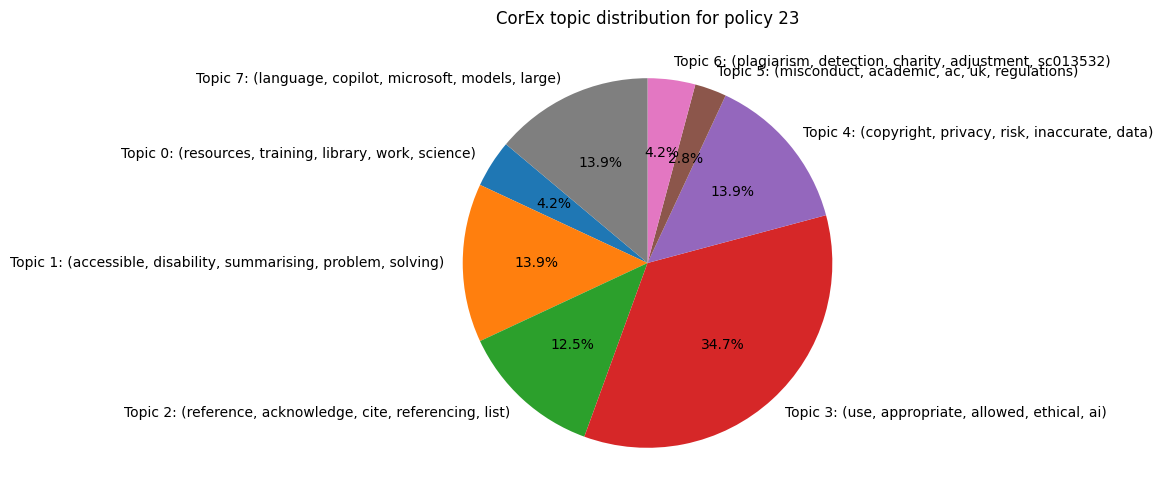

In [87]:
# Show policy text + metadata and visualize topic distributions (CorEx + LDA)
import pprint


idx = 23

# Print metadata and full policy text
print(f"Policy index: {idx}")
# meta_cols = ['Course', 'Institution', 'Contributor']
# print(df1.loc[idx, meta_cols].to_dict())
print("\nFull policy text:\n")
pprint.pprint(df1.loc[idx, 'Policy Text'])


# # Print LDA topic distribution if available
# if 'lda_results' in globals():
#     lda_dist = lda_results[idx]
#     print("LDA topic distribution:")
#     for i, p in enumerate(lda_dist):
#         print(f"  Topic {i}: {p:.4f}")
#     print()

# CorEx topic values for this policy (uses existing CorEx_topic_* columns)
corex_topic_cols = corex_topics  # provided in notebook as a list of column names
corex_vals = df1.loc[idx, corex_topic_cols].astype(float).values
print("CorEx topic values (from df1):")
for i, v in enumerate(corex_vals):
    print(f"  {corex_topic_cols[i]}: {v:.4f}")
print()

# Print top words for each CorEx topic from the fitted corex_model (if available)
if 'corex_model' in globals():
    print("Top words per CorEx topic:")
    for i, topic in enumerate(corex_model.get_topics(n_words=8)):
        top_words = [w for w, _, _ in topic]
        print(f"  Topic {i}: {', '.join(top_words)}")
    print()

# Pie chart of CorEx topic distribution for this policy (include first word of each topic)
plt.figure(figsize=(6,6))
if corex_vals.sum() == 0:
    # no topics matched -- show a single grey slice
    plt.pie([1], labels=['No matching CorEx topics'], colors=['lightgrey'], autopct='%1.1f%%', startangle=140)
else:
    # try to get the first word for each CorEx topic from the fitted model
    first_words = []
    if 'corex_model' in globals():
        topics = corex_model.get_topics(n_words=1)
        # topics is a list where each element is a list/tuple of (word, score, ...)
        for t in topics[:len(corex_vals)]:
            first_words.append(t[0][0] if t and len(t) > 0 else '')
    else:
        first_words = [''] * len(corex_vals)

    # build labels with the top 3 words for each CorEx topic (fallback to existing first_words)
    if 'corex_model' in globals():
        topics_top3 = corex_model.get_topics(n_words=5)
        label_words = []
        for t in topics_top3[:len(corex_vals)]:
            if t:
                # each t is list of tuples like (word, score, ...)
                words = [w for w, *rest in t][:5]
                label_words.append(', '.join(words))
            else:
                label_words.append('')
    else:
        label_words = [fw or '' for fw in first_words]

    labels = [f"Topic {i}: ({label_words[i]})" if label_words[i] else f"Topic {i}" for i in range(len(corex_vals))]
    plt.pie(corex_vals, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title(f"CorEx topic distribution for policy {idx}")
plt.show()

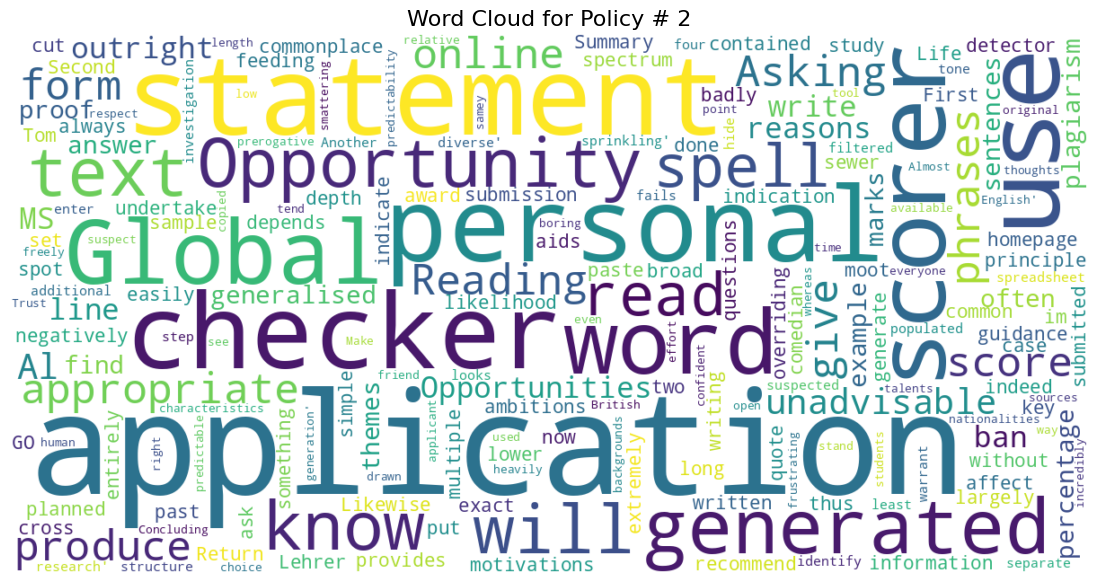

Saved word cloud to: ./policies/wordclouds/wordcloud_policy_2.png


In [122]:
import sys, subprocess
from wordcloud import WordCloud, STOPWORDS

# Word cloud for policy index 23
policy_idx = 2

# get policy text safely
text = df1.at[policy_idx, 'Policy Text'] if 'Policy Text' in df1.columns else None

if not isinstance(text, str) or not text.strip():
    print(f"No usable text found for policy index {policy_idx}.")
else:
    # extend stopwords with some common artifacts from scraped policies
    stopwords = set(STOPWORDS)
    stopwords.update(['https', 'http', 'www', 'com', 'org', 'edu', 'page', 'policy', 'policytext', 'generative', 'ai', 'may', 'take'])

    wc = WordCloud(width=1200, height=600, background_color='white',
                   stopwords=stopwords, collocations=False).generate(text)

    plt.figure(figsize=(14, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Policy # {policy_idx}', fontsize=16)
    plt.show()

    # optionally save
    out_dir = os.path.join('.', 'policies', 'wordclouds')
    os.makedirs(out_dir, exist_ok=True)
    out_file = os.path.join(out_dir, f'wordcloud_policy_{policy_idx}.png')
    wc.to_file(out_file)
    print(f"Saved word cloud to: {out_file}")

In [ ]:
#

## Evaluating Quality of CorEx Topic modelling 


TODO: add paper/citation for these 

### Total Correlation (TC) Metric
Good: Increases sharply then stabilises

Bad: Flat or very low values


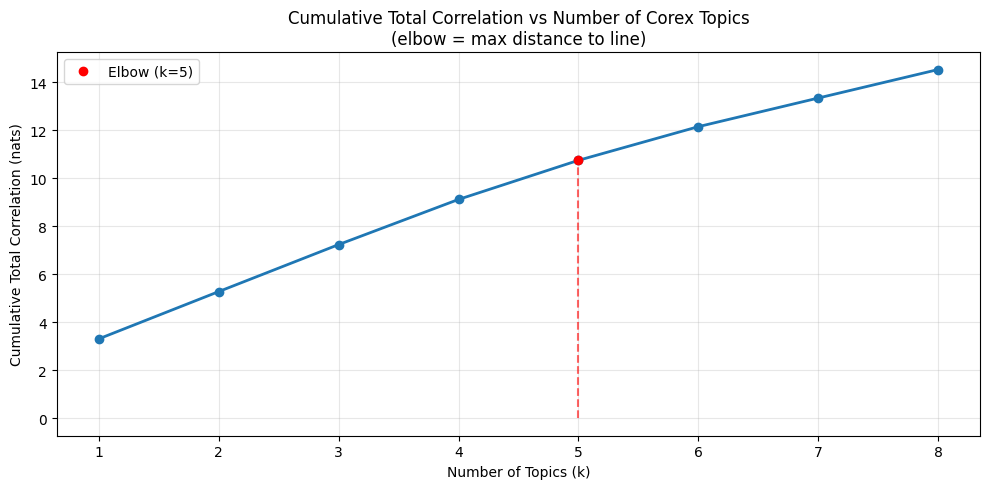

Evaluated 8 topics. Detected elbow at k = 5 (cumulative TC = 10.7401).


In [88]:
import numpy as np

# Plot total correlation (TC) vs number of CorEx topics and find elbow point
# Relies on `corex_model` being present in the notebook and having `.tcs` attribute.

import matplotlib.pyplot as plt

if 'corex_model' not in globals() or not hasattr(corex_model, "tcs"):
	raise RuntimeError("corex_model with attribute .tcs not found in the notebook. Fit a Corex model first.")

# per-topic TC values (convert to numpy array)
tcs = np.asarray(corex_model.tcs).astype(float)
if tcs.size == 0:
	raise RuntimeError("corex_model.tcs is empty.")

# sort topics by contribution (descending) and compute cumulative TC for 1..K topics
tcs_sorted_desc = np.sort(tcs)[::-1]
cumulative_tc = np.cumsum(tcs_sorted_desc)
k_vals = np.arange(1, len(cumulative_tc) + 1)

# simple "elbow" detection using max distance to line from first to last point
x1, y1 = k_vals[0], cumulative_tc[0]
x2, y2 = k_vals[-1], cumulative_tc[-1]
# line distance formula
num = np.abs((y2 - y1) * k_vals - (x2 - x1) * cumulative_tc + x2 * y1 - y2 * x1)
den = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
distances = num / den
elbow_idx = int(np.argmax(distances))  # zero-based index into k_vals
elbow_k = k_vals[elbow_idx]
elbow_tc = cumulative_tc[elbow_idx]

# Plot cumulative TC vs number of topics
plt.figure(figsize=(10, 5))
plt.plot(k_vals, cumulative_tc, marker='o', linewidth=2)
plt.plot(elbow_k, elbow_tc, 'ro', label=f'Elbow (k={elbow_k})')
plt.vlines(elbow_k, ymin=0, ymax=elbow_tc, colors='r', linestyles='--', alpha=0.6)
plt.xlabel('Number of Topics (k)')
plt.ylabel('Cumulative Total Correlation (nats)')
plt.title('Cumulative Total Correlation vs Number of Corex Topics\n(elbow = max distance to line)')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print a brief summary
print(f"Evaluated {len(k_vals)} topics. Detected elbow at k = {elbow_k} (cumulative TC = {elbow_tc:.4f}).")

## Topic Coherence (C_V)
Good: > 0.4–0.5 (context-dependent)

Bad: < 0.3 (less interpretable)


In [89]:
import re
from collections import defaultdict
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd

# Compute topic coherence using Gensim's CoherenceModel for available topic word lists


# Prepare tokenized texts for gensim (lowercased, alphabetic tokens)
# uses existing `documents` variable (list of raw strings)
def tokenize_for_gensim(text):
    return re.findall(r'\b[a-zA-Z]+\b', text.lower())

texts = [tokenize_for_gensim(t) for t in documents]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(t) for t in texts]

# Helper to normalize topic word lists to match gensim tokenization
def normalize_topic_words(word_list):
    return [re.sub(r'[^a-zA-Z]', '', w).lower() for w in word_list if re.sub(r'[^a-zA-Z]', '', w)]

# Collect topic-word lists from known variables (LDA, chunked LDA, CorEx, generic `topic_words`)
models_topics = defaultdict(list)

# topic_words (often created from lda.components_)
if 'topic_words' in globals() and isinstance(topic_words, dict):
    models_topics['LDA'] = [normalize_topic_words(ws) for ws in topic_words.values()]

# lda_chunks (use vocab_chunks + lda_chunks.components_ if available)
if 'lda_chunks' in globals() and 'vocab_chunks' in globals():
    try:
        n_topics_chunks = lda_chunks.components_.shape[0]
        topics_lc = []
        for comp in lda_chunks.components_:
            idx = comp.argsort()[::-1][:n_top_words]
            topics_lc.append([vocab_chunks[i] for i in idx])
        models_topics['LDA_chunks'] = [normalize_topic_words(ws) for ws in topics_lc]
    except Exception:
        pass

# lda (global lda) using vocab if present
if 'lda' in globals() and 'vocab' in globals():
    try:
        topics_lda = []
        for comp in lda.components_:
            idx = comp.argsort()[::-1][:n_top_words]
            topics_lda.append([vocab[i] for i in idx])
        models_topics['LDA_full'] = [normalize_topic_words(ws) for ws in topics_lda]
    except Exception:
        pass

# CorEx: extract topics from corex_model if present
if 'corex_model' in globals():
    try:
        corex_topics_raw = corex_model.get_topics(n_words=n_top_words)
        # corex returns list of tuples like (word, score, something)
        corex_topics = []
        for t in corex_topics_raw:
            corex_topics.append([w for (w, *_) in t])
        models_topics['CorEx'] = [normalize_topic_words(ws) for ws in corex_topics]
    except Exception:
        pass

# fallback: if variable `topics` present (already topic word tuples)
if 'topics' in globals() and isinstance(topics, list) and topics:
    try:
        models_topics['topics_var'] = []
        for t in topics:
            # t might be list of (word,score,...)
            if isinstance(t, (list, tuple)):
                words = []
                for elt in t:
                    if isinstance(elt, (list, tuple)):
                        words.append(str(elt[0]))
                    else:
                        words.append(str(elt))
                models_topics['topics_var'].append(normalize_topic_words(words[:n_top_words]))
    except Exception:
        pass

# If nothing found, abort
if not models_topics:
    raise RuntimeError("No topic-word sets found in notebook globals (checked topic_words, lda, lda_chunks, corex_model, topics).")

# Compute coherence scores (c_v and u_mass) per topic and aggregated per model
results = []
for model_name, topic_lists in models_topics.items():
    for tidx, tw in enumerate(topic_lists):
        if not tw:
            continue
        # c_v (requires texts)
        cm_cv = CoherenceModel(topics=[tw], texts=texts, dictionary=dictionary, coherence='c_v')
        score_cv = cm_cv.get_coherence()
        # u_mass (requires corpus + dictionary)
        cm_um = CoherenceModel(topics=[tw], corpus=corpus, dictionary=dictionary, coherence='u_mass')
        score_um = cm_um.get_coherence()
        results.append({
            'model': model_name,
            'topic': tidx,
            'top_words': tw,
            'coherence_c_v': score_cv,
            'coherence_u_mass': score_um
        })

# Summarize: per-topic and per-model average
df_coh = pd.DataFrame(results)
if df_coh.empty:
    raise RuntimeError("No coherence results produced.")

summary = df_coh.groupby('model').agg(
    topics_count=('topic', 'count'),
    mean_c_v=('coherence_c_v', 'mean'),
    mean_u_mass=('coherence_u_mass', 'mean')
).reset_index()

# Display results
print("Per-topic coherence (first rows):")
print(df_coh.sort_values(['model','topic']).head(20).to_string(index=False))
print("\nPer-model summary:")
print(summary.to_string(index=False))

# Save results into notebook variables for further inspection
globals()['df_coherence_per_topic'] = df_coh
globals()['df_coherence_summary'] = summary

/usr/local/python/3.12.1/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Per-topic coherence (first rows):
     model  topic                                                                                                  top_words  coherence_c_v  coherence_u_mass
     CorEx      0                    [resources, training, library, work, science, sussex, oxford, access, centre, journals]       0.366210         -3.048738
     CorEx      1        [accessible, disability, summarising, problem, solving, generating, revision, visual, tasks, based]       0.398274         -1.424731
     CorEx      2 [reference, acknowledge, cite, referencing, list, citation, harvard, learning, march, citethemrightonline]       0.596210         -1.687555
     CorEx      3       [use, appropriate, allowed, ethical, ai, assessment, permitted, responsible, inappropriate, clearly]       0.456570         -0.628440
     CorEx      4      [copyright, privacy, risk, inaccurate, data, protection, personal, property, intellectual, sensitive]       0.685315         -0.586771
     CorEx      5 

Good: > 0.4–0.5 (context-dependent)


Bad: < 0.3 (less interpretable)

## Topic Diversity
Measures redundancy (word overlap across topics).

Good: > 0.8


Bad: < 0.7 (redundant topics)


In [ ]:
from itertools import combinations
import pandas as pd

# Compute Topic Diversity for CorEx topics (word-overlap based metrics)
# - Topic Diversity (unique) = |unique top words across topics| / (n_topics * n_top_words)
# - Topic Diversity (1 - mean pairwise Jaccard) = 1 - mean_jaccard_similarity

if 'corex_model' not in globals():
    raise RuntimeError("corex_model is not present in the notebook. Fit a Corex model first.")

top_n = 10
topics_raw = corex_model.get_topics(n_words=top_n)  # list of lists of tuples like (word, score, ...)
# normalize to lists of words
topic_word_lists = [[w for (w, *_) in t][:top_n] for t in topics_raw]
n_topics = len(topic_word_lists)
if n_topics == 0:
    raise RuntimeError("corex_model.get_topics returned no topics.")

# Unique-based diversity
all_top_words = set(w for lst in topic_word_lists for w in lst)
td_unique = len(all_top_words) / (n_topics * top_n)

# Pairwise Jaccard and 1 - mean_jaccard diversity
pair_jaccards = []
for a, b in combinations(range(n_topics), 2):
    sa, sb = set(topic_word_lists[a]), set(topic_word_lists[b])
    inter = sa & sb
    union = sa | sb
    j = len(inter) / len(union) if union else 0.0
    pair_jaccards.append(j)
mean_jaccard = float(pd.Series(pair_jaccards).mean()) if pair_jaccards else 0.0
td_1_minus_mean_jaccard = 1.0 - mean_jaccard

# Per-topic uniqueness ratio (fraction of top_n words unique to that topic)
per_topic_uniqueness = []
for i, lst in enumerate(topic_word_lists):
    others = set(w for j, other in enumerate(topic_word_lists) if j != i for w in other)
    uniq = set(lst) - others
    per_topic_uniqueness.append({
        "topic_idx": i,
        "top_words": lst,
        "unique_count": len(uniq),
        "uniqueness_ratio": len(uniq) / top_n
    })

df_topic_div = pd.DataFrame(per_topic_uniqueness)

# Save globals for later inspection
globals()['corex_topic_word_lists'] = topic_word_lists
globals()['corex_td_unique'] = td_unique
globals()['corex_td_jaccard'] = td_1_minus_mean_jaccard
globals()['df_corex_topic_diversity'] = df_topic_div

# Print summary
print(f"CorEx topics: {n_topics}, top_n={top_n}")
print(f"Topic Diversity (unique words / total top words) = {td_unique:.4f}  "
      f"  (Good > 0.8, Bad < 0.7)")
print(f"Topic Diversity (1 - mean pairwise Jaccard) = {td_1_minus_mean_jaccard:.4f}  "
      f"  (Good > 0.8, Bad < 0.7)")
print("\nPer-topic uniqueness (first rows):")
print(df_topic_div[['topic_idx', 'unique_count', 'uniqueness_ratio', 'top_words']].to_string(index=False))

CorEx topics: 3, top_n=10
Topic Diversity (unique words / total top words) = 1.0000    (Good > 0.8, Bad < 0.7)
Topic Diversity (1 - mean pairwise Jaccard) = 1.0000    (Good > 0.8, Bad < 0.7)

Per-topic uniqueness (first rows):
 topic_idx  unique_count  uniqueness_ratio                                                                                       top_words
         0            10               1.0                             [development, uk, ac, https, www, pdf, skills, aspx, adoption, php]
         1            10               1.0  [ethical, biases, data, risk, compliance, assessment, brief, limitations, permitted, property]
         2            10               1.0 [teaching, staff, students, learning, support, education, university, programmes, policy, text]


In [ ]:
for i, topic in enumerate(topics):
    print(f"Topic {i+1}: {', '.join(topic)}")

Topic 1: development
Topic 2: ethical
Topic 3: teaching


In [ ]:
# from corextopic import vis_rep as vt

# from corextopic import corextopic as ct
# from corextopic.vis_rep import vis_rep as vt

# Visualize Corex topics using vis_rep
# This cell expects `corex_model` (the fitted Corex model) and `words` (vocabulary array) to be present
# from earlier cells (they are defined in cells 47/52). It will try a few import paths for vis_rep.

# pick the topic model object available in the notebook

topic_model = corex_model
# ensure words (vocabulary) is available
column_label = words

# Call vis_rep to produce the interactive visualization artifacts
# prefix='' writes files without additional prefix; adjust if you want a filename prefix.
ct.vis_rep(topic_model, column_label=column_label, prefix='visRepResults')

print("vis_rep invoked. Check notebook output or generated HTML/JS files in the working directory.")

AttributeError: module 'corextopic.corextopic' has no attribute 'vis_rep'

### TODO compare actual policy text to see why some policies dont have certain topics at all. 

paper contribution: 
- finding the best eval metrics are best to evaluate the polices 
- statistical basis, literature, etc to justify the selected metrics. and then verfiy them via prolific survey.

### TF-IDF 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Compute TF-IDF matrix for all policies
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

# Rank policies by their total TF-IDF score (sum of all terms per document)
tfidf_scores = np.asarray(tfidf_matrix.sum(axis=1)).flatten()
policy_ranking = np.argsort(tfidf_scores)[::-1]  # Descending order

# Show top 10 policies by TF-IDF score
top_n = 10
print("Top policies by TF-IDF score:")
for i in range(top_n):
    idx = policy_ranking[i]
    print(f"Policy {idx}: TF-IDF score = {tfidf_scores[idx]:.3f}")
    print(documents[idx][:200], '...\n')  # Print first 200 chars for preview

NameError: name 'documents' is not defined

Radar chart

1- use TFIDF to rank policeis, and compare top 5 on the radar, top 5 or bottom 5,


2- allow users to select a policy to compare with


### Stance Detection and Argument Mining


find a standardise benchmark dataset to train the algo, and use policy as test data.
see if the policies are FOR, AGAINST, or NEUTRAL, w.r.t to GEN AI ADOPTION


https://arxiv.org/abs/2001.01565  Stance Detection Benchmark: How Robust Is Your Stance Detection?

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset

# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("krishnagarg09/stance-detection-semeval2016")
model = AutoModelForSequenceClassification.from_pretrained("krishnagarg09/stance-detection-semeval2016")

# load dataset
dataset = load_dataset("krishnagarg09/SemEval2016Task6")

# prepare input (convert dataset Column to a list of strings)
text_column = dataset['test']['Tweet']
texts = [str(t) for t in list(text_column)]

# tokenize (batch)
encoded_input = tokenizer(texts, return_tensors='pt', add_special_tokens=True, max_length=128, padding=True, truncation=True)

# forward pass
output = model(**encoded_input)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


: 

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

# Load the Hugging Face dataset + model/checkpoint "krishnagarg09/stance-detection-semeval2016"
# and run fast batched inference over the notebook `policies` Series.
# Result stored in df1['stance_hf'].


# # load model and tokenizer
# tokenizer = AutoTokenizer.from_pretrained("krishnagarg09/stance-detection-semeval2016")
# model = AutoModelForSequenceClassification.from_pretrained("krishnagarg09/stance-detection-semeval2016")

# # load dataset
# dataset = load_dataset("krishnagarg09/SemEval2016Task6")



MODEL_ID = "krishnagarg09/SemEval2016Task6"
BATCH = BATCH_SIZE  # uses existing notebook variable
DEVICE = torch.device(DEVICE)

try:
    ds_hf = load_dataset(MODEL_ID)
    print(f"Loaded dataset: {MODEL_ID}")
except Exception as e:
    print(f"Failed to load dataset {MODEL_ID}: {e}")
    ds_hf = None

# Load tokenizer & model (checkpoint contains a fine-tuned classifier)
try:
    tokenizer_hf = AutoTokenizer.from_pretrained(MODEL_ID)
    model_hf = AutoModelForSequenceClassification.from_pretrained(MODEL_ID).to(DEVICE)
    model_hf.eval()
    id2label = getattr(model_hf.config, "id2label", None) or {i: str(i) for i in range(model_hf.config.num_labels)}
    print(f"Loaded model/tokenizer from {MODEL_ID}. Labels: {id2label}")
except Exception as e:
    print(f"Failed to load model/tokenizer from {MODEL_ID}: {e}")
    raise

# Prepare texts (uses existing `policies` Series)
texts = policies.fillna("").astype(str).tolist()

def predict_labels(texts, tokenizer, model, batch_size=BATCH, device=DEVICE):
    preds = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        enc = tokenizer(batch_texts, truncation=True, padding=True, max_length=256, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            out = model(**enc)
            logits = out.logits
            batch_preds = torch.argmax(logits, dim=-1).cpu().numpy()
        preds.extend(batch_preds.tolist())
    return preds

pred_ids = predict_labels(texts, tokenizer_hf, model_hf, batch_size=BATCH, device=DEVICE)
pred_labels = [id2label.get(int(i), str(i)) for i in pred_ids]

# Save to dataframe
df1['stance_hf'] = pred_labels

print("Unique predicted stance labels:", sorted(df1['stance_hf'].unique()))
print(df1[['stance_hf']].head())

Generating test split: 100%|██████████| 1080/1080 [00:00<00:00, 52793.59 examples/s]


Loaded dataset: krishnagarg09/SemEval2016Task6
Failed to load model/tokenizer from krishnagarg09/SemEval2016Task6: krishnagarg09/SemEval2016Task6 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`


OSError: krishnagarg09/SemEval2016Task6 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`

In [ ]:

import numpy as np
import torch

# stance_detection_pipeline.py
# Cell to load a standard stance-detection benchmark (SemEval-2016 Task 6 recommended),
# fine-tune a transformer for 3-way stance (FAVOR/AGAINST/NEUTRAL), and apply to notebook policies.
# Assumes `policies` (pd.Series) and `df1` (DataFrame) already exist in the notebook.

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer
)

# CONFIG - change model or dataset as needed
HF_MODEL = "roberta-base"
CANDIDATE_DATASETS = [
    "semeval_2016_task6",   # common name but may not exist on hf; loader will try multiple candidates
    "semeval2016/task6",
    "stance",               # placeholder / common name
    "krishnagarg09/stance-detection-semeval2016"               # placeholder
    
]
TRAIN_SUBSAMPLE = 2000   # limit for quick fine-tuning in dev environment; set None to use full train set
EPOCHS = 2
BATCH_SIZE = 8
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def try_load_benchmark():
    """Try several dataset ids on HF datasets until one loads; return dataset dict or None."""
    for name in CANDIDATE_DATASETS:
        try:
            ds = load_dataset(name)
            print(f"Loaded dataset: {name}")
            return ds
        except Exception:
            continue
    # If none loaded, give clear instruction
    raise RuntimeError(
        "Could not auto-load a benchmark from Hugging Face with tried names. "
        "Recommended dataset: 'SemEval-2016 Task 6 (Stance Detection)'. "
        "Please download it and convert to HuggingFace Dataset or provide path. "
        "Example: prepare a CSV with columns ['text','label'] and use `datasets.load_dataset('csv', data_files=...)`."
    )

def detect_text_label_columns(dataset):
    """Heuristically pick text and label columns from a dataset split."""
    sample = dataset[list(dataset.keys())[0]].select(range(min(20, len(dataset[list(dataset.keys())[0]]))))
    # choose first string column longer than 10 chars as text
    text_col = None
    label_col = None
    for col, dtype in sample.features.items():
        if dtype.dtype == "string":
            # pick as text if many chars
            example = sample[col][0]
            if isinstance(example, str) and len(example) > 10:
                text_col = col
                break
    # find label-like column (string or class label)
    for col, dtype in sample.features.items():
        if col == text_col:
            continue
        # class labels may be ClassLabel feature
        if hasattr(dtype, "names") or dtype.dtype == "string" or dtype.dtype == "int64":
            label_col = col
            break
    if text_col is None:
        # fallback to first string column
        for col, dtype in sample.features.items():
            if dtype.dtype == "string":
                text_col = col
                break
    return text_col, label_col

def prepare_dataset_for_training(ds, text_col, label_col):
    """Return a dataset with 'text' and 'label' columns, label names resolved."""
    # pick train split (or first available split)
    split_name = "train" if "train" in ds else list(ds.keys())[0]
    ds_split = ds[split_name]
    # normalize columns
    def _map_example(ex):
        return {"text": ex[text_col], "label": ex[label_col]}
    ds_small = ds_split.map(_map_example)
    # if label is string, convert to ClassLabel
    if ds_small.features["label"].dtype == "string":
        # build label list
        unique_labels = sorted(list({l for l in ds_small["label"] if isinstance(l, str)}))
        label2id = {l: i for i, l in enumerate(unique_labels)}
        def _encode(ex):
            return {"label": label2id.get(ex["label"], -1)}
        ds_small = ds_small.map(_encode)
        ds_small = ds_small.filter(lambda x: x["label"] >= 0)
        label_names = unique_labels
    elif hasattr(ds_small.features["label"], "names"):
        label_names = ds_small.features["label"].names
    else:
        # numeric labels; infer unique set
        unique = sorted(list(set(ds_small["label"])))
        label_names = [str(u) for u in unique]
        # remap to contiguous ids
        id_map = {old: new for new, old in enumerate(unique)}
        def _remap(ex):
            return {"label": id_map[ex["label"]]}
        ds_small = ds_small.map(_remap)
    return ds_small, label_names

def tokenize_and_split(ds, tokenizer, text_col="text"):
    def preprocess(x):
        return tokenizer(x[text_col], truncation=True, padding="max_length", max_length=256)
    ds_tok = ds.map(preprocess, batched=True)
    # split train/validation if only train exists
    if "validation" not in ds_tok and "test" not in ds_tok:
        ds_tok = ds_tok.train_test_split(test_size=0.1, seed=42)
        ds_tok["validation"] = ds_tok["test"]
    return ds_tok

def quick_finetune(ds_tok, label_names, model_name=HF_MODEL):
    num_labels = len(label_names)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(DEVICE)
    args = TrainingArguments(
        output_dir="./tmp_stance_trainer",
        evaluation_strategy="epoch",
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,
        logging_steps=50,
        save_strategy="no",
        disable_tqdm=False,
        seed=42
    )
    def compute_metrics(eval_pred):
        preds, labels = eval_pred
        preds = np.argmax(preds, axis=1)
        acc = (preds == labels).mean()
        return {"accuracy": acc}
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=ds_tok["train"] if "train" in ds_tok else ds_tok[list(ds_tok.keys())[0]],
        eval_dataset=ds_tok["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )
    trainer.train()
    return trainer

def predict_policies(trainer, tokenizer, label_names, texts):
    enc = tokenizer(texts, truncation=True, padding=True, return_tensors="pt", max_length=512).to(DEVICE)
    model = trainer.model
    model.eval()
    with torch.no_grad():
        outputs = model(**enc)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1).cpu().numpy()
    labels = [label_names[p] for p in preds]
    return labels

# === Pipeline execution (will attempt to auto-load a benchmark) ===
try:
    ds = try_load_benchmark()
    text_col, label_col = detect_text_label_columns(ds)
    print("Detected text column:", text_col, "label column:", label_col)
    ds_prepared, label_names = prepare_dataset_for_training(ds, text_col, label_col)

    if TRAIN_SUBSAMPLE:
        ds_prepared = ds_prepared.select(range(min(TRAIN_SUBSAMPLE, len(ds_prepared))))

    tokenizer = AutoTokenizer.from_pretrained(HF_MODEL)
    ds_tok = tokenize_and_split(ds_prepared, tokenizer)
    trainer = quick_finetune(ds_tok, label_names, model_name=HF_MODEL)

    # Apply to notebook policies (pd.Series) -> provide predictions and save to df1
    policy_texts = policies.fillna("").astype(str).tolist()
    preds = predict_policies(trainer, tokenizer, label_names, policy_texts)
    df1['stance_pred'] = preds
    print("Predictions added to df1['stance_pred']. Unique predictions:", sorted(df1['stance_pred'].unique()))
except Exception as e:
    print("Stance pipeline failed or dataset not found.")
    print("Error:", e)
    print("\nTo proceed manually:\n"
          "1) Obtain SemEval-2016 Task 6 stance dataset (train/dev/test) and convert to a csv with columns 'text','label'.\n"
          "2) Load it with `datasets.load_dataset('csv', data_files=...)`.\n"
          "3) Then use the functions in this file to tokenize, finetune and predict.\n")

Stance pipeline failed or dataset not found.
Error: Could not auto-load a benchmark from Hugging Face with tried names. Recommended dataset: 'SemEval-2016 Task 6 (Stance Detection)'. Please download it and convert to HuggingFace Dataset or provide path. Example: prepare a CSV with columns ['text','label'] and use `datasets.load_dataset('csv', data_files=...)`.

To proceed manually:
1) Obtain SemEval-2016 Task 6 stance dataset (train/dev/test) and convert to a csv with columns 'text','label'.
2) Load it with `datasets.load_dataset('csv', data_files=...)`.
3) Then use the functions in this file to tokenize, finetune and predict.



In [ ]:

import numpy as np
import torch

# stance_detection_pipeline.py
# Cell to load a standard stance-detection benchmark (SemEval-2016 Task 6 recommended),
# fine-tune a transformer for 3-way stance (FAVOR/AGAINST/NEUTRAL), and apply to notebook policies.
# Assumes `policies` (pd.Series) and `df1` (DataFrame) already exist in the notebook.

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer
)

# CONFIG - change model or dataset as needed
HF_MODEL = "roberta-base"
CANDIDATE_DATASETS = [
    "semeval_2016_task6",   # common name but may not exist on hf; loader will try multiple candidates
    "semeval2016/task6",
    "stance",               # placeholder / common name
    "xstance"               # placeholder
]
TRAIN_SUBSAMPLE = 2000   # limit for quick fine-tuning in dev environment; set None to use full train set
EPOCHS = 2
BATCH_SIZE = 8
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def try_load_benchmark():
    """Try several dataset ids on HF datasets until one loads; return dataset dict or None."""
    for name in CANDIDATE_DATASETS:
        try:
            ds = load_dataset(name)
            print(f"Loaded dataset: {name}")
            return ds
        except Exception:
            continue
    # If none loaded, give clear instruction
    raise RuntimeError(
        "Could not auto-load a benchmark from Hugging Face with tried names. "
        "Recommended dataset: 'SemEval-2016 Task 6 (Stance Detection)'. "
        "Please download it and convert to HuggingFace Dataset or provide path. "
        "Example: prepare a CSV with columns ['text','label'] and use `datasets.load_dataset('csv', data_files=...)`."
    )

def detect_text_label_columns(dataset):
    """Heuristically pick text and label columns from a dataset split."""
    sample = dataset[list(dataset.keys())[0]].select(range(min(20, len(dataset[list(dataset.keys())[0]]))))
    # choose first string column longer than 10 chars as text
    text_col = None
    label_col = None
    for col, dtype in sample.features.items():
        if dtype.dtype == "string":
            # pick as text if many chars
            example = sample[col][0]
            if isinstance(example, str) and len(example) > 10:
                text_col = col
                break
    # find label-like column (string or class label)
    for col, dtype in sample.features.items():
        if col == text_col:
            continue
        # class labels may be ClassLabel feature
        if hasattr(dtype, "names") or dtype.dtype == "string" or dtype.dtype == "int64":
            label_col = col
            break
    if text_col is None:
        # fallback to first string column
        for col, dtype in sample.features.items():
            if dtype.dtype == "string":
                text_col = col
                break
    return text_col, label_col

def prepare_dataset_for_training(ds, text_col, label_col):
    """Return a dataset with 'text' and 'label' columns, label names resolved."""
    # pick train split (or first available split)
    split_name = "train" if "train" in ds else list(ds.keys())[0]
    ds_split = ds[split_name]
    # normalize columns
    def _map_example(ex):
        return {"text": ex[text_col], "label": ex[label_col]}
    ds_small = ds_split.map(_map_example)
    # if label is string, convert to ClassLabel
    if ds_small.features["label"].dtype == "string":
        # build label list
        unique_labels = sorted(list({l for l in ds_small["label"] if isinstance(l, str)}))
        label2id = {l: i for i, l in enumerate(unique_labels)}
        def _encode(ex):
            return {"label": label2id.get(ex["label"], -1)}
        ds_small = ds_small.map(_encode)
        ds_small = ds_small.filter(lambda x: x["label"] >= 0)
        label_names = unique_labels
    elif hasattr(ds_small.features["label"], "names"):
        label_names = ds_small.features["label"].names
    else:
        # numeric labels; infer unique set
        unique = sorted(list(set(ds_small["label"])))
        label_names = [str(u) for u in unique]
        # remap to contiguous ids
        id_map = {old: new for new, old in enumerate(unique)}
        def _remap(ex):
            return {"label": id_map[ex["label"]]}
        ds_small = ds_small.map(_remap)
    return ds_small, label_names

def tokenize_and_split(ds, tokenizer, text_col="text"):
    def preprocess(x):
        return tokenizer(x[text_col], truncation=True, padding="max_length", max_length=256)
    ds_tok = ds.map(preprocess, batched=True)
    # split train/validation if only train exists
    if "validation" not in ds_tok and "test" not in ds_tok:
        ds_tok = ds_tok.train_test_split(test_size=0.1, seed=42)
        ds_tok["validation"] = ds_tok["test"]
    return ds_tok

def quick_finetune(ds_tok, label_names, model_name=HF_MODEL):
    num_labels = len(label_names)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(DEVICE)
    args = TrainingArguments(
        output_dir="./tmp_stance_trainer",
        evaluation_strategy="epoch",
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,
        logging_steps=50,
        save_strategy="no",
        disable_tqdm=False,
        seed=42
    )
    def compute_metrics(eval_pred):
        preds, labels = eval_pred
        preds = np.argmax(preds, axis=1)
        acc = (preds == labels).mean()
        return {"accuracy": acc}
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=ds_tok["train"] if "train" in ds_tok else ds_tok[list(ds_tok.keys())[0]],
        eval_dataset=ds_tok["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )
    trainer.train()
    return trainer

def predict_policies(trainer, tokenizer, label_names, texts):
    enc = tokenizer(texts, truncation=True, padding=True, return_tensors="pt", max_length=512).to(DEVICE)
    model = trainer.model
    model.eval()
    with torch.no_grad():
        outputs = model(**enc)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1).cpu().numpy()
    labels = [label_names[p] for p in preds]
    return labels

# === Pipeline execution (will attempt to auto-load a benchmark) ===
try:
    ds = try_load_benchmark()
    text_col, label_col = detect_text_label_columns(ds)
    print("Detected text column:", text_col, "label column:", label_col)
    ds_prepared, label_names = prepare_dataset_for_training(ds, text_col, label_col)

    if TRAIN_SUBSAMPLE:
        ds_prepared = ds_prepared.select(range(min(TRAIN_SUBSAMPLE, len(ds_prepared))))

    tokenizer = AutoTokenizer.from_pretrained(HF_MODEL)
    ds_tok = tokenize_and_split(ds_prepared, tokenizer)
    trainer = quick_finetune(ds_tok, label_names, model_name=HF_MODEL)

    # Apply to notebook policies (pd.Series) -> provide predictions and save to df1
    policy_texts = policies.fillna("").astype(str).tolist()
    preds = predict_policies(trainer, tokenizer, label_names, policy_texts)
    df1['stance_pred'] = preds
    print("Predictions added to df1['stance_pred']. Unique predictions:", sorted(df1['stance_pred'].unique()))
except Exception as e:
    print("Stance pipeline failed or dataset not found.")
    print("Error:", e)
    print("\nTo proceed manually:\n"
          "1) Obtain SemEval-2016 Task 6 stance dataset (train/dev/test) and convert to a csv with columns 'text','label'.\n"
          "2) Load it with `datasets.load_dataset('csv', data_files=...)`.\n"
          "3) Then use the functions in this file to tokenize, finetune and predict.\n")

### Export results

In [ ]:
cols = list(df1.columns)
cols.remove('Policy Text')
# cols.remove('Contributor')
# cols.remove('Rights for Reuse')
# cols.insert(0, cols.pop(cols.index('Institution')))
df1[cols].to_csv('./policies/Policies_with_EvalMetrics.csv', index=False)

Notice the highest Gunning fog index indicating that it can be comprehended only by readers who have graduated college. On the other hand, the item which has a much lower fog index can be comprehended by 5th grade students.

#### Why is the number of generated topics not always equal to the number of anchors?

In CorEx, the number of topics (`n_hidden`) sets the maximum number of topics the model will generate. The anchors you provide are used to guide some of these topics, but if you provide fewer anchors than `n_hidden`, the remaining topics are discovered automatically without anchors. If you provide more anchors than `n_hidden`, only the first `n_hidden` anchors are used. Thus, the number of generated topics is always equal to `n_hidden`, not necessarily the number of anchors.